In [71]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import scipy as sp

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.style.use('ggplot')
sns.set(style='whitegrid')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

from sklearn.metrics import classification_report,confusion_matrix

In [577]:
loans_df = pd.read_csv('Loan_status_2007-2020Q3.txt', index_col=0)

/Users/gianluca/python_venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (1,48,58,117,127,128,129,132,133,134,137) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [578]:
loans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2925493 entries, 0 to 2925492
Columns: 142 entries, Unnamed: 0 to debt_settlement_flag
dtypes: float64(106), int64(1), object(35)
memory usage: 3.1+ GB


## 1. Feature Selection

Text(0, 0.5, 'Feature count')

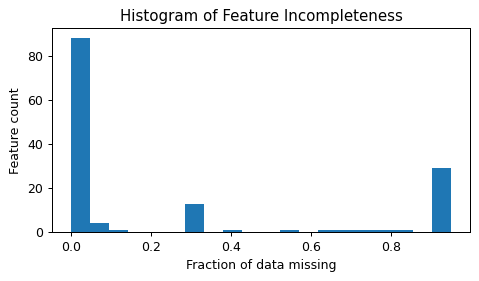

In [579]:
# Histogram of feature completeness

missing_fractions = loans_df.isnull().mean().sort_values(ascending=False)

plt.figure(figsize=(6,3), dpi=90)
missing_fractions.plot.hist(bins=20)
plt.title('Histogram of Feature Incompleteness')
plt.xlabel('Fraction of data missing')
plt.ylabel('Feature count')

In [580]:
# Drop features missing more than 30% data 

drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))
loans_df.drop(labels=drop_list, axis=1, inplace=True)

In [581]:
print(list(loans_df.columns))

['Unnamed: 0', 'id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'total_bal_il', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'tot

In [582]:
# Consider only loans which have been fully paid or charged off

# Target Variable
loans_df['loan_status'].value_counts(dropna=False)

Fully Paid                                             1497783
Current                                                1031016
Charged Off                                             362548
Late (31-120 days)                                       16154
In Grace Period                                          10028
Late (16-30 days)                                         2719
Issued                                                    2062
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                    433
NaN                                                          1
Name: loan_status, dtype: int64

In [583]:
loans_df = loans_df.loc[loans_df['loan_status'].isin(['Fully Paid', 'Charged Off'])]

In [584]:
def plot_var(col_name, full_name, continuous):
    """
    Visualize a variable with and without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    # Plot without loan status
    if continuous:
        sns.distplot(loans_df.loc[loans_df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(loans_df[col_name], order=sorted(loans_df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)

    # Plot with loan status
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', data=loans_df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
    else:
        charge_off_rates = loans_df.groupby(col_name)['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
        sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Charged-off')
        ax2.set_title('Charge-off Rate by ' + full_name)
    ax2.set_xlabel(full_name)
    
    plt.tight_layout()

### Individual feature analysis

### 1.1 id

In [585]:
loans_df['id'].describe()

count      1860331
unique     1860331
top       83886078
freq             1
Name: id, dtype: int64

In [586]:
loans_df.drop('id', axis=1, inplace=True)

### 1.2 loan_amnt

In [587]:
loans_df['loan_amnt'].describe()

count    1.860331e+06
mean     1.458827e+04
std      8.970471e+03
min      5.000000e+02
25%      7.950000e+03
50%      1.200000e+04
75%      2.000000e+04
max      4.000000e+04
Name: loan_amnt, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


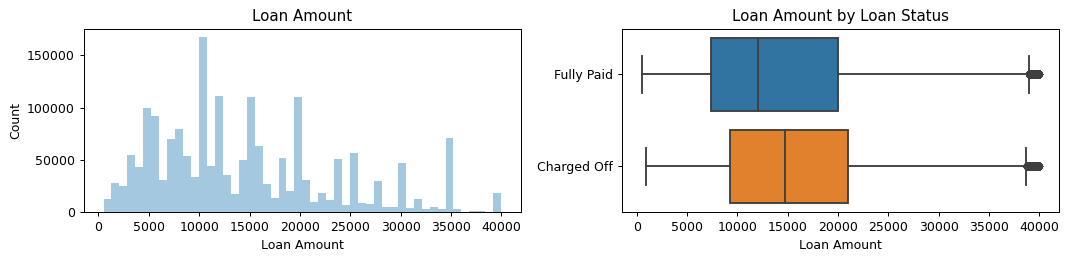

In [588]:
plot_var('loan_amnt', 'Loan Amount', continuous=True)

### 1.3 funded_amnt, funded_amnt_inv

In [589]:
loans_df['funded_amnt'].describe()

count    1.860331e+06
mean     1.458218e+04
std      8.967823e+03
min      5.000000e+02
25%      7.925000e+03
50%      1.200000e+04
75%      2.000000e+04
max      4.000000e+04
Name: funded_amnt, dtype: float64

In [590]:
loans_df['funded_amnt_inv'].describe()

count    1.860331e+06
mean     1.456467e+04
std      8.969319e+03
min      0.000000e+00
25%      7.800000e+03
50%      1.200000e+04
75%      2.000000e+04
max      4.000000e+04
Name: funded_amnt_inv, dtype: float64

In [591]:
# The above two are sufficiently similar to loan_amnt that they can be removed

loans_df.drop('funded_amnt', axis=1, inplace=True)
loans_df.drop('funded_amnt_inv', axis=1, inplace=True)

### 1.4 term

In [592]:
loans_df['term'].value_counts(dropna=False)

 36 months    1393299
 60 months     467032
Name: term, dtype: int64

In [593]:
loans_df['term'] = loans_df['term'].apply(lambda s: np.int8(s.split()[0]))
loans_df['term'].value_counts(normalize=True)

36    0.748952
60    0.251048
Name: term, dtype: float64

In [594]:
loans_df.groupby('term')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

term
36    0.156242
60    0.310163
Name: loan_status, dtype: float64

### 1.5 int_rate

In [595]:
# Let's remove % percent sign from `int_rate` and convert it into `float`
loans_df.int_rate = loans_df.int_rate.map(lambda x: x.replace('%','')).astype(np.float64)

In [596]:
loans_df['int_rate'].describe()

count    1.860331e+06
mean     1.317013e+01
std      4.828300e+00
min      5.310000e+00
25%      9.560000e+00
50%      1.269000e+01
75%      1.599000e+01
max      3.099000e+01
Name: int_rate, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


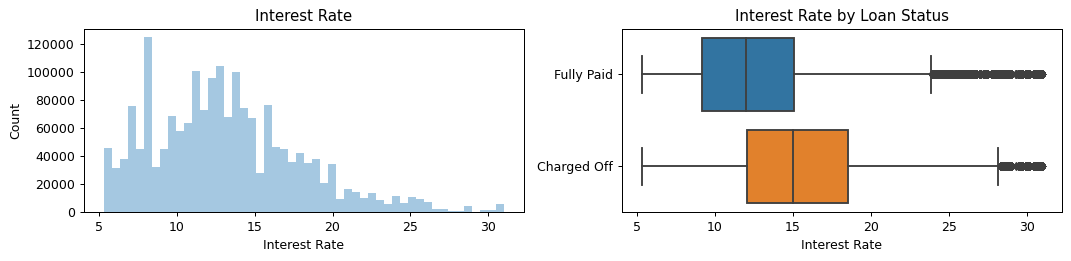

In [597]:
plot_var('int_rate', 'Interest Rate', continuous=True)

### 1.6 installment

In [598]:
loans_df['installment'].describe()

count    1.860331e+06
mean     4.402559e+02
std      2.669094e+02
min      4.930000e+00
25%      2.469900e+02
50%      3.736300e+02
75%      5.849600e+02
max      1.719830e+03
Name: installment, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


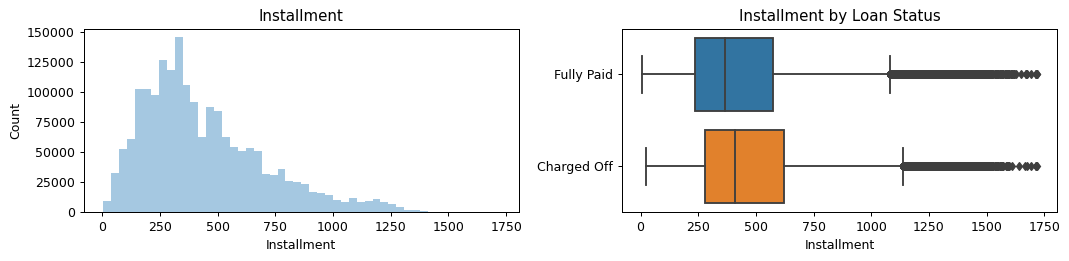

In [599]:
plot_var('installment', 'Installment', continuous=True)

### 1.7 grade and sub_grade

In [600]:
print(sorted(loans_df['grade'].unique()))

['A', 'B', 'C', 'D', 'E', 'F', 'G']


In [601]:
print(sorted(loans_df['sub_grade'].unique()))

['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']


In [602]:
loans_df.drop('grade', axis=1, inplace=True)

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


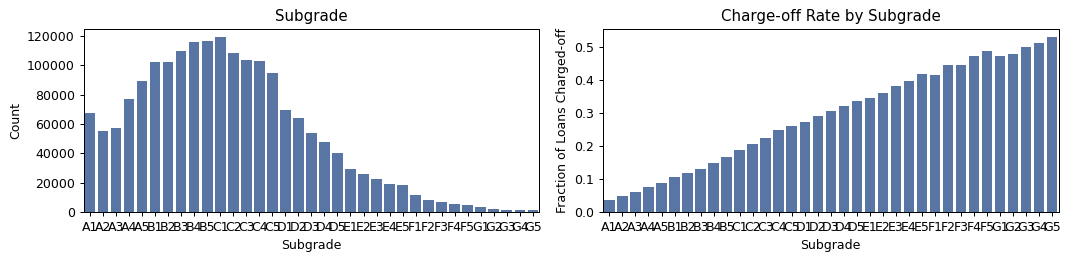

In [603]:
plot_var('sub_grade', 'Subgrade', continuous=False)

### 1.8 emp_title

In [604]:
loans_df['emp_title'].describe()

count     1728877
unique     456676
top       Teacher
freq        30748
Name: emp_title, dtype: object

In [605]:
loans_df.drop(labels='emp_title', axis=1, inplace=True)

### 1.9 emp_length

In [606]:
loans_df['emp_length'].value_counts(dropna=False).sort_index()

1 year       122924
10+ years    611330
2 years      168516
3 years      149271
4 years      112211
5 years      115872
6 years       85354
7 years       78141
8 years       78646
9 years       67170
< 1 year     153700
NaN          117196
Name: emp_length, dtype: int64

In [607]:
loans_df['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)

In [608]:
loans_df['emp_length'].replace('< 1 year', '0 years', inplace=True)

In [609]:
def emp_length_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])

In [610]:
loans_df['emp_length'] = loans_df['emp_length'].apply(emp_length_to_int)

In [611]:
loans_df['emp_length'].value_counts(dropna=False).sort_index()

0.0     153700
1.0     122924
2.0     168516
3.0     149271
4.0     112211
5.0     115872
6.0      85354
7.0      78141
8.0      78646
9.0      67170
10.0    611330
NaN     117196
Name: emp_length, dtype: int64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


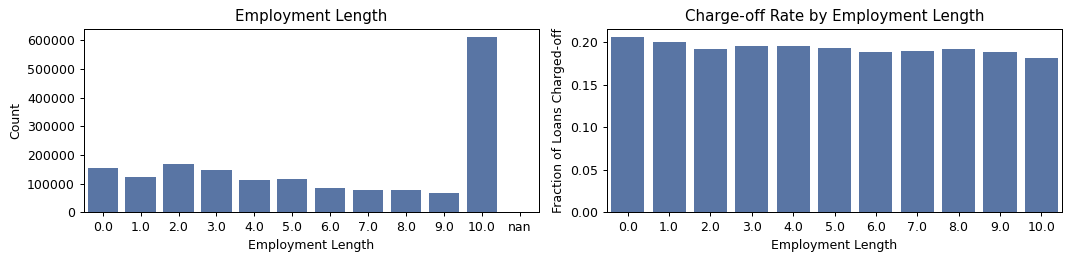

In [612]:
plot_var('emp_length', 'Employment Length', continuous=False)

In [613]:
loans_df.drop('emp_length', axis=1, inplace=True)

### 1.10 home_ownership

In [614]:
loans_df['home_ownership'].value_counts(dropna=False)

MORTGAGE    918028
RENT        735358
OWN         205578
ANY           1174
OTHER          144
NONE            49
Name: home_ownership, dtype: int64

In [615]:
loans_df['home_ownership'].replace(['NONE', 'ANY'], 'OTHER', inplace=True)

In [616]:
loans_df['home_ownership'].value_counts(dropna=False)

MORTGAGE    918028
RENT        735358
OWN         205578
OTHER         1367
Name: home_ownership, dtype: int64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


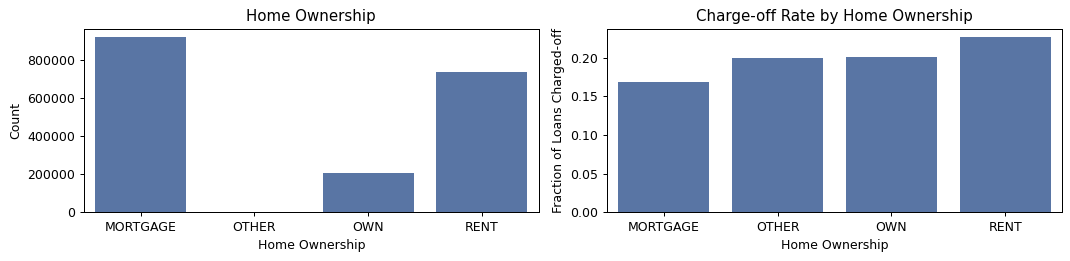

In [617]:
plot_var('home_ownership', 'Home Ownership', continuous=False)

In [618]:
loans_df.groupby('home_ownership')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

home_ownership
MORTGAGE    0.168312
OTHER       0.199707
OWN         0.201077
RENT        0.226316
Name: loan_status, dtype: float64

### 1.11 annual_inc

In [619]:
loans_df['annual_inc'].describe()

count    1.860331e+06
mean     7.736956e+04
std      1.178218e+05
min      0.000000e+00
25%      4.600000e+04
50%      6.500000e+04
75%      9.200000e+04
max      1.100000e+08
Name: annual_inc, dtype: float64

In [620]:
loans_df['log_annual_inc'] = loans_df['annual_inc'].apply(lambda x: np.log10(x+1))

In [621]:
loans_df.drop('annual_inc', axis=1, inplace=True)

In [622]:
loans_df['log_annual_inc'].describe()

count    1.860331e+06
mean     4.814749e+00
std      2.661675e-01
min      0.000000e+00
25%      4.662767e+00
50%      4.812920e+00
75%      4.963793e+00
max      8.041393e+00
Name: log_annual_inc, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


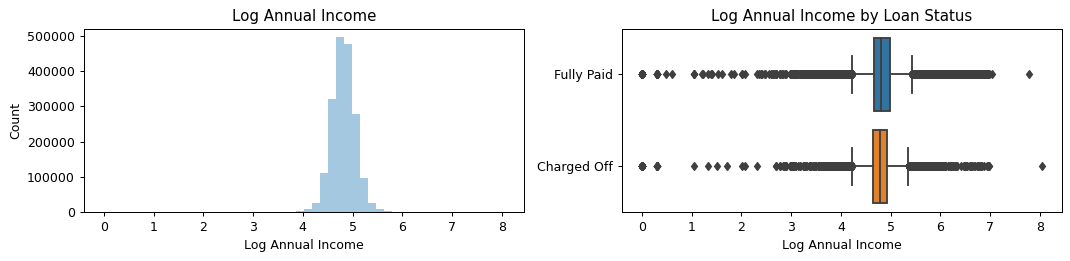

In [623]:
plot_var('log_annual_inc', 'Log Annual Income', continuous=True)

### 1.12 verification_status

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


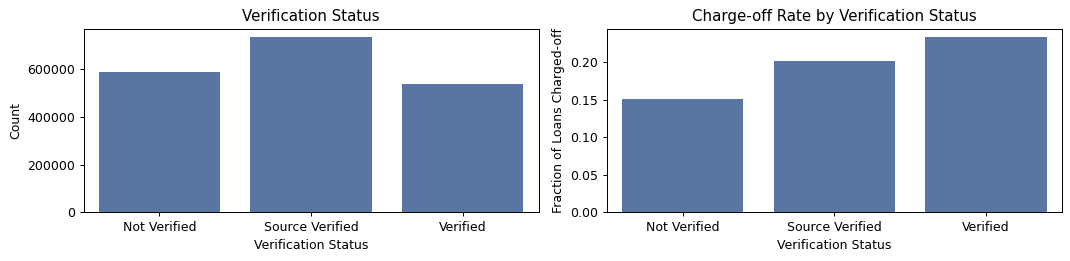

In [624]:
plot_var('verification_status', 'Verification Status', continuous=False)

### 1.13 issue_d

In [625]:
# Use issue_d for train test split later on

### 1.14 loan_status

In [626]:
# This is the target variable

loans_df['loan_status'].value_counts()

Fully Paid     1497783
Charged Off     362548
Name: loan_status, dtype: int64

### 1.15 pymnt_plan

In [627]:
loans_df['pymnt_plan'].sample(5)

1898587    n
1676838    n
2428895    n
2006966    n
2491709    n
Name: pymnt_plan, dtype: object

In [628]:
loans_df['pymnt_plan'].value_counts()

n    1860331
Name: pymnt_plan, dtype: int64

In [629]:
loans_df['pymnt_plan'].describe()

count     1860331
unique          1
top             n
freq      1860331
Name: pymnt_plan, dtype: object

In [630]:
loans_df.drop('pymnt_plan', axis=1, inplace=True)

### 1.16 url

In [631]:
loans_df['url'].sample(5)

2189059    https://lendingclub.com/browse/loanDetail.acti...
2181321    https://lendingclub.com/browse/loanDetail.acti...
2883846    https://lendingclub.com/browse/loanDetail.acti...
2779555    https://lendingclub.com/browse/loanDetail.acti...
67406      https://lendingclub.com/browse/loanDetail.acti...
Name: url, dtype: object

In [632]:
loans_df['url'].describe()

count                                               1860331
unique                                              1860331
top       https://lendingclub.com/browse/loanDetail.acti...
freq                                                      1
Name: url, dtype: object

In [633]:
loans_df.drop('url', axis=1, inplace=True)

### 1.17 purpose

In [634]:
loans_df['purpose'].value_counts()

debt_consolidation    1063459
credit_card            412844
home_improvement       123861
other                  113589
major_purchase          41750
medical                 22578
small_business          20515
car                     20215
vacation                13333
moving                  13203
house                   11099
wedding                  2298
renewable_energy         1260
educational               327
Name: purpose, dtype: int64

In [635]:
loans_df.groupby('purpose')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off'].sort_values()

purpose
wedding               0.121845
car                   0.141182
credit_card           0.168521
educational           0.171254
home_improvement      0.172209
vacation              0.177979
major_purchase        0.184671
other                 0.200239
medical               0.204048
debt_consolidation    0.206408
renewable_energy      0.216667
moving                0.220859
house                 0.221732
small_business        0.285840
Name: loan_status, dtype: float64

### 1.18 title

In [636]:
loans_df['title'].describe()

count                1838925
unique                 61685
top       Debt consolidation
freq                  941169
Name: title, dtype: object

In [637]:
loans_df['title'].value_counts().head(10)

Debt consolidation         941169
Credit card refinancing    366391
Home improvement           111152
Other                      102322
Major purchase              36294
Medical expenses            20548
Business                    16806
Car financing               16802
Debt Consolidation          15695
Vacation                    12273
Name: title, dtype: int64

In [638]:
loans_df.drop('title', axis=1, inplace=True)

### 1.19 zip_code, addr_state

In [639]:
loans_df['zip_code'].sample(5)

221010     981xx
2396574    700xx
1589900    069xx
2406466    936xx
1707349    113xx
Name: zip_code, dtype: object

In [640]:
loans_df['zip_code'].nunique()

949

In [641]:
loans_df['addr_state'].sample(5)

2068108    PA
1677342    NV
442857     WI
1685552    NY
1066184    NY
Name: addr_state, dtype: object

In [642]:
loans_df['addr_state'].nunique()

51

In [643]:
loans_df.drop(labels='zip_code', axis=1, inplace=True)

### 1.20 dti

In [644]:
loans_df['dti'].describe()

count    1.859223e+06
mean     1.856774e+01
std      1.309153e+01
min     -1.000000e+00
25%      1.182000e+01
50%      1.771000e+01
75%      2.429000e+01
max      9.990000e+02
Name: dti, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Debt-to-income Ratio')

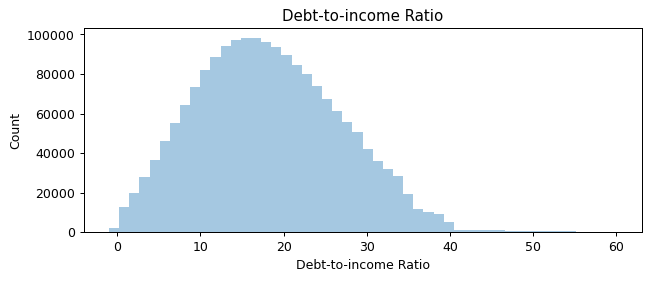

In [645]:
plt.figure(figsize=(8,3), dpi=90)
sns.distplot(loans_df.loc[loans_df['dti'].notnull() & (loans_df['dti']<60), 'dti'], kde=False)
plt.xlabel('Debt-to-income Ratio')
plt.ylabel('Count')
plt.title('Debt-to-income Ratio')

In [646]:
(loans_df['dti']>=60).sum()

4874

### 1.21 delinq_2yrs

In [647]:
loans_df['delinq_2yrs'].describe()

count    1.860331e+06
mean     3.128750e-01
std      8.754565e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.200000e+01
Name: delinq_2yrs, dtype: float64

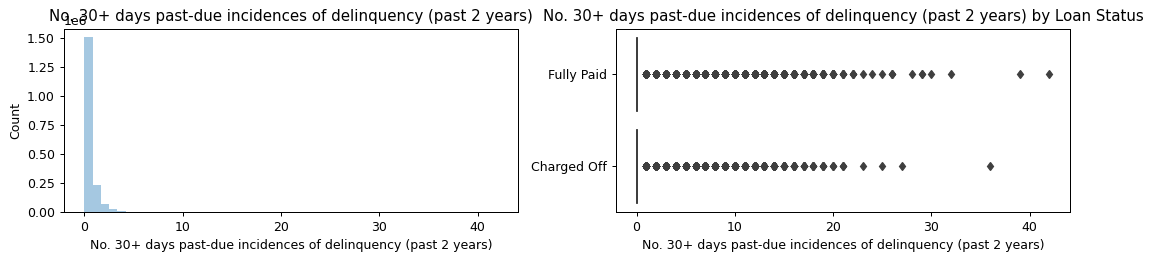

In [648]:
plot_var('delinq_2yrs', 'No. 30+ days past-due incidences of delinquency (past 2 years)', continuous=True)

### 1.22 earliest_cr_line

In [649]:
loans_df['earliest_cr_line'].sample(5)

2812613    Apr-2001
1715038    Feb-1996
2647853    Aug-1999
1553510    Jan-1994
2297941    Dec-2001
Name: earliest_cr_line, dtype: object

In [650]:
loans_df['earliest_cr_line'].isnull().any()

False

In [651]:
loans_df['earliest_cr_line'] = loans_df['earliest_cr_line'].apply(lambda s: int(s[-4:]))

In [652]:
loans_df['earliest_cr_line'].describe()

count    1.860331e+06
mean     1.999279e+03
std      7.771737e+00
min      1.933000e+03
25%      1.995000e+03
50%      2.001000e+03
75%      2.005000e+03
max      2.017000e+03
Name: earliest_cr_line, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


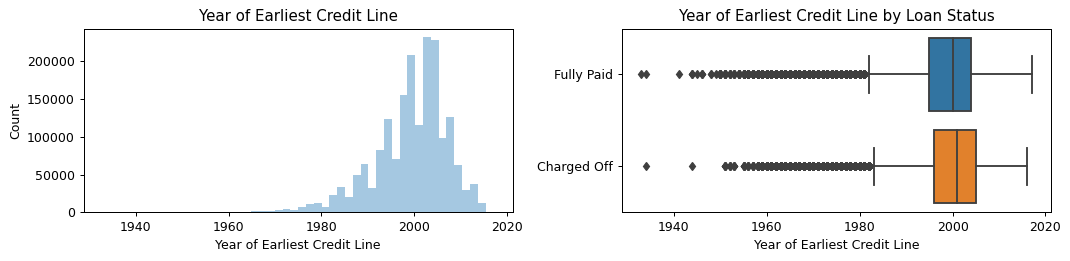

In [653]:
plot_var('earliest_cr_line', 'Year of Earliest Credit Line', continuous=True)

### 1.23 fico_range_low, fico_range_high

In [654]:
loans_df[['fico_range_low', 'fico_range_high']].describe()

,fico_range_low,fico_range_high
count,1.860331e+06,1.860331e+06
mean,6.976785e+02,7.016786e+02
std,3.270865e+01,3.270940e+01
min,6.250000e+02,6.290000e+02
25%,6.700000e+02,6.740000e+02
50%,6.900000e+02,6.940000e+02
75%,7.150000e+02,7.190000e+02
max,8.450000e+02,8.500000e+02


In [655]:
loans_df[['fico_range_low','fico_range_high']].corr()

,fico_range_low,fico_range_high
fico_range_low,1.0,1.0
fico_range_high,1.0,1.0


In [656]:
# We only need to keep one of the FICO scores. We take the average of the two and call it fico_score

loans_df['fico_score'] = 0.5*loans_df['fico_range_low'] + 0.5*loans_df['fico_range_high']

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


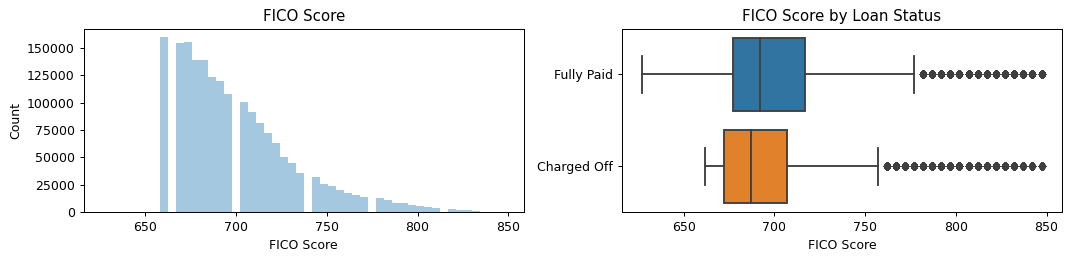

In [657]:
plot_var('fico_score', 'FICO Score', continuous=True)

### 1.24 inq_last_6mths

In [658]:
loans_df['inq_last_6mths'].describe()

count    1.860330e+06
mean     6.125763e-01
std      9.018184e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      8.000000e+00
Name: inq_last_6mths, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


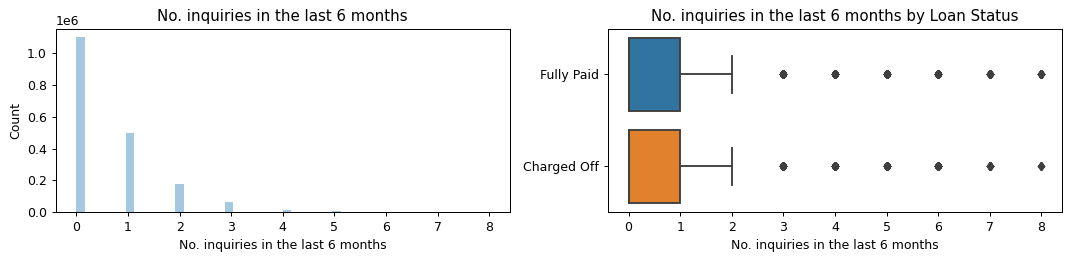

In [659]:
plot_var('inq_last_6mths', 'No. inquiries in the last 6 months', continuous=True)

### 1.25 open_acc

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Number of Open Credit Lines')

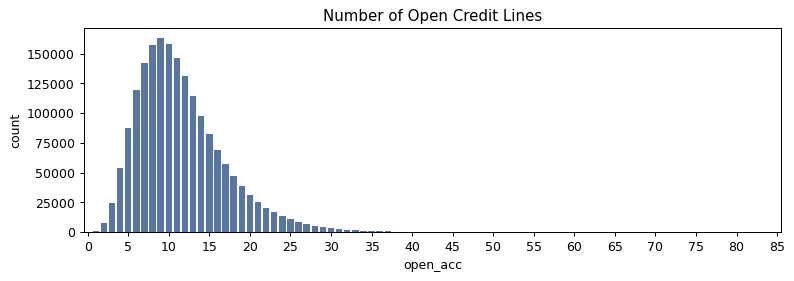

In [660]:
plt.figure(figsize=(10,3), dpi=90)
sns.countplot(loans_df['open_acc'], order=sorted(loans_df['open_acc'].unique()), color='#5975A4', saturation=1)
_, _ = plt.xticks(np.arange(0, 90, 5), np.arange(0, 90, 5))
plt.title('Number of Open Credit Lines')

### 1.26 pub_rec

In [661]:
loans_df['pub_rec'].value_counts().sort_index()

0.0     1552452
1.0      260561
2.0       30892
3.0        9484
4.0        3473
5.0        1656
6.0         830
7.0         379
8.0         214
9.0         118
10.0         77
11.0         55
12.0         32
13.0         22
14.0         10
15.0         10
16.0          9
17.0          5
18.0          6
19.0          7
20.0          3
21.0          6
22.0          3
23.0          2
24.0          3
25.0          1
28.0          4
31.0          1
32.0          1
34.0          1
37.0          1
40.0          1
44.0          1
45.0          1
46.0          1
47.0          1
49.0          2
52.0          1
54.0          1
61.0          2
63.0          1
86.0          1
Name: pub_rec, dtype: int64

In [662]:
loans_df.groupby('loan_status')['pub_rec'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,362548.0,0.237091,0.637907,0.0,0.0,0.0,0.0,86.0
Fully Paid,1497783.0,0.201339,0.577843,0.0,0.0,0.0,0.0,63.0


### 1.27 revol_bal

In [663]:
loans_df['revol_bal'].describe()

count    1.860331e+06
mean     1.628541e+04
std      2.246811e+04
min      0.000000e+00
25%      5.842000e+03
50%      1.107000e+04
75%      1.977000e+04
max      2.904836e+06
Name: revol_bal, dtype: float64

In [664]:
loans_df['log_revol_bal'] = loans_df['revol_bal'].apply(lambda x: np.log10(x+1))

In [665]:
loans_df.drop('revol_bal', axis=1, inplace=True)

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


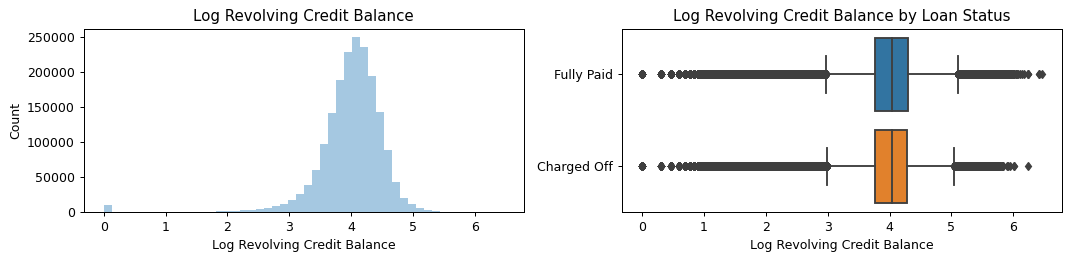

In [666]:
plot_var('log_revol_bal', 'Log Revolving Credit Balance', continuous=True)

In [667]:
loans_df.groupby('loan_status')['log_revol_bal'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,362548.0,3.973350,0.539168,0.0,3.766115,4.039136,4.278456,6.242223
Fully Paid,1497783.0,3.987726,0.551916,0.0,3.766710,4.045519,4.300400,6.463122


### 1.28 revol_util

In [668]:
# Let's remove % percent sign from `revol_util` and convert it into `float`
loans_df.revol_util = loans_df.revol_util.map(lambda x: str(x).replace('%','')).astype(np.float64)
loans_df['revol_util'].head()

0    83.7
1     9.4
2    98.5
3    21.0
4    53.9
Name: revol_util, dtype: float64

In [669]:
loans_df['revol_util'].describe()

count    1.858933e+06
mean     5.046432e+01
std      2.478987e+01
min      0.000000e+00
25%      3.160000e+01
50%      5.050000e+01
75%      6.960000e+01
max      8.923000e+02
Name: revol_util, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


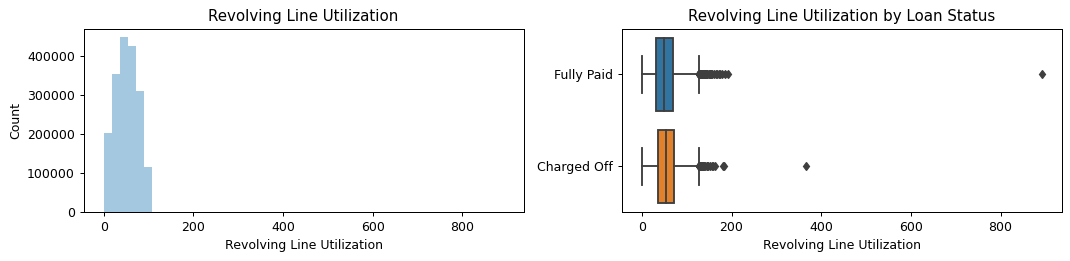

In [670]:
plot_var('revol_util', 'Revolving Line Utilization', continuous=True)

In [671]:
loans_df.groupby('loan_status')['revol_util'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,362279.0,52.955286,24.245129,0.0,35.0,53.5,71.6,366.6
Fully Paid,1496654.0,49.861357,24.882490,0.0,30.8,49.8,69.0,892.3


### 1.29 total_acc

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Total Number of Credit Lines')

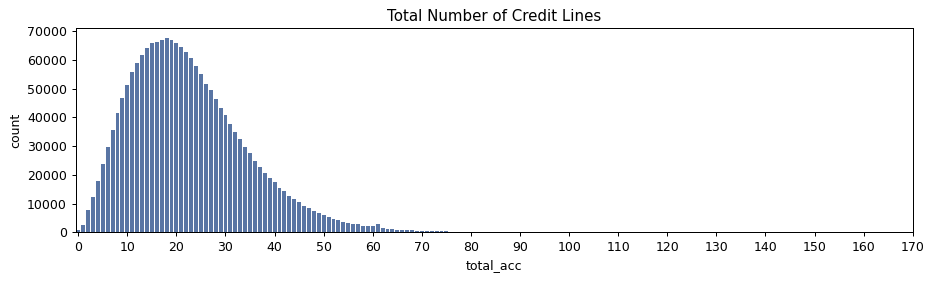

In [672]:
plt.figure(figsize=(12,3), dpi=90)
sns.countplot(loans_df['total_acc'], order=sorted(loans_df['total_acc'].unique()), color='#5975A4', saturation=1)
_, _ = plt.xticks(np.arange(0, 176, 10), np.arange(0, 176, 10))
plt.title('Total Number of Credit Lines')

In [673]:
loans_df.groupby('loan_status')['total_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,362548.0,24.212874,12.163333,2.0,15.0,22.0,31.0,176.0
Fully Paid,1497783.0,24.689546,12.015939,2.0,16.0,23.0,31.0,165.0


### 1.30 initial_list_status

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


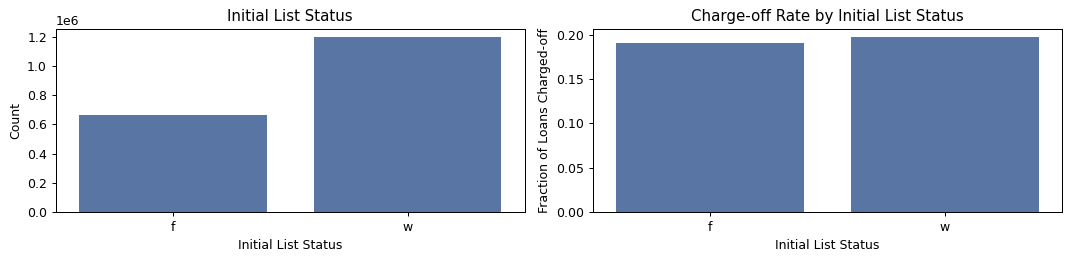

In [674]:
plot_var('initial_list_status', 'Initial List Status', continuous=False)

### 1.31 out_prncp, out_prncp_inv

In [675]:
loans_df['out_prncp'].describe()

count    1860331.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: out_prncp, dtype: float64

In [676]:
loans_df['out_prncp_inv'].describe()

count    1860331.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: out_prncp_inv, dtype: float64

In [677]:
loans_df.drop('out_prncp', axis=1, inplace=True)

In [678]:
loans_df.drop('out_prncp_inv', axis=1, inplace=True)

### 1.32 total_pymnt, total_pymnt_inv

In [679]:
loans_df['total_pymnt'].describe()

count    1.860331e+06
mean     1.516862e+04
std      1.067915e+04
min      0.000000e+00
25%      6.904605e+03
50%      1.230347e+04
75%      2.111064e+04
max      6.717438e+04
Name: total_pymnt, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


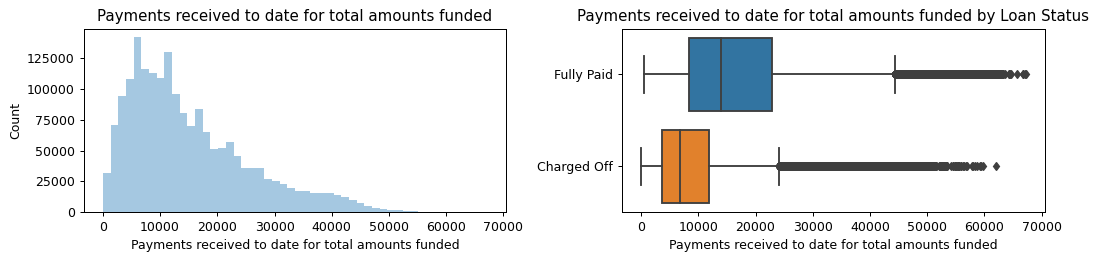

In [680]:
plot_var('total_pymnt', 'Payments received to date for total amounts funded', continuous=True)

In [681]:
loans_df['total_pymnt_inv'].describe()

count    1.860331e+06
mean     1.515005e+04
std      1.067765e+04
min      0.000000e+00
25%      6.887260e+03
50%      1.228849e+04
75%      2.109053e+04
max      6.717438e+04
Name: total_pymnt_inv, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


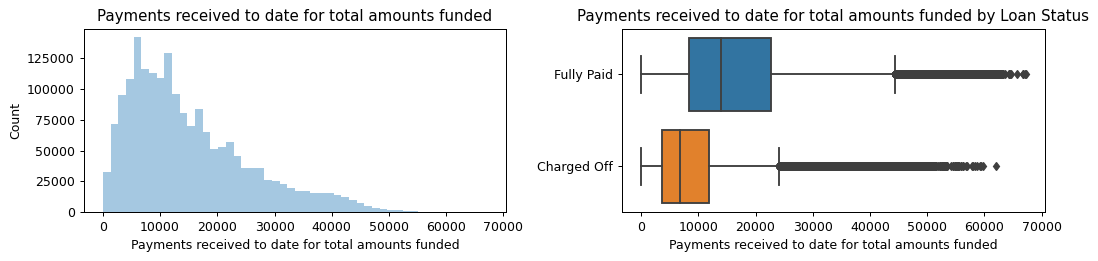

In [682]:
plot_var('total_pymnt_inv', 'Payments received to date for total amounts funded', continuous=True)

In [683]:
loans_df.drop('total_pymnt_inv', axis=1, inplace=True)

### 1.33 total_rec_prncp

In [684]:
loans_df['total_rec_prncp'].describe()

count    1.860331e+06
mean     1.238601e+04
std      9.069623e+03
min      0.000000e+00
25%      5.060100e+03
50%      1.000000e+04
75%      1.800000e+04
max      4.000000e+04
Name: total_rec_prncp, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


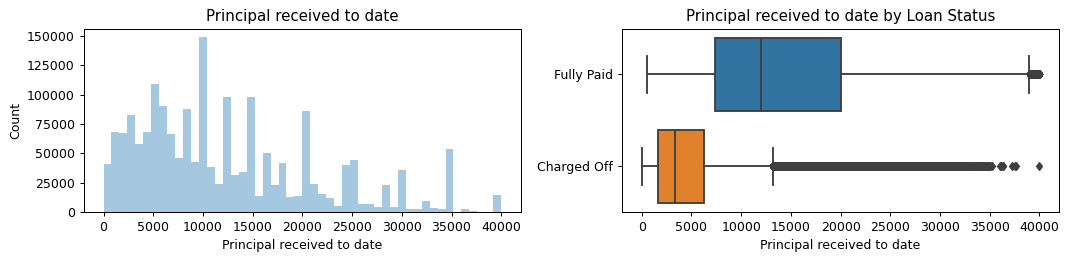

In [685]:
plot_var('total_rec_prncp', 'Principal received to date', continuous=True)

### 1.34 total_rec_int

In [686]:
loans_df['total_rec_int'].describe()

count    1.860331e+06
mean     2.513191e+03
std      2.754893e+03
min      0.000000e+00
25%      7.771500e+02
50%      1.603050e+03
75%      3.188465e+03
max      3.171437e+04
Name: total_rec_int, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


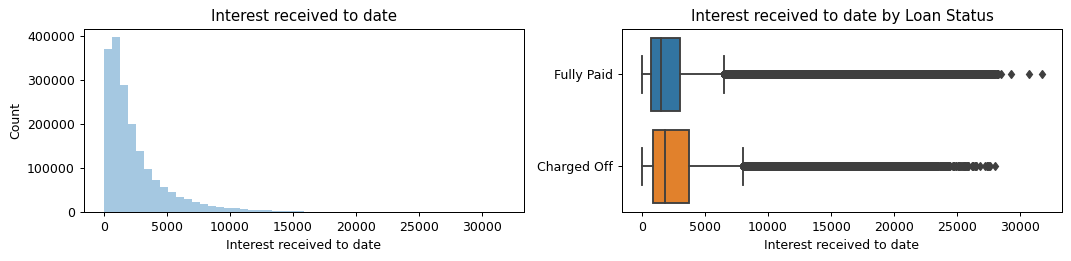

In [687]:
plot_var('total_rec_int', 'Interest received to date', continuous=True)

### 1.35 total_rec_late_fee

In [688]:
loans_df['total_rec_late_fee'].describe()

count    1.860331e+06
mean     2.031812e+00
std      1.407489e+01
min     -5.100000e-09
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.598520e+03
Name: total_rec_late_fee, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


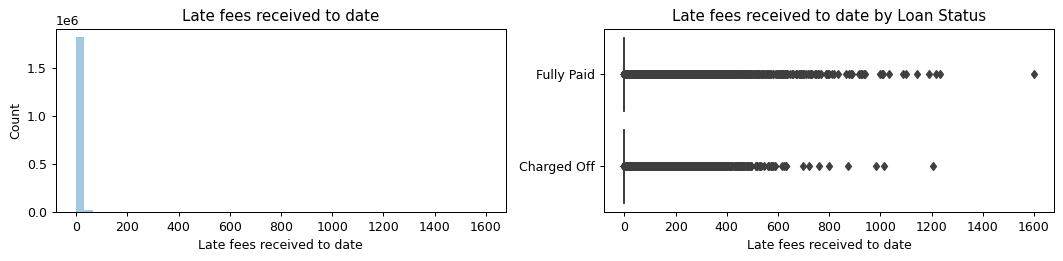

In [689]:
plot_var('total_rec_late_fee', 'Late fees received to date', continuous=True)

### 1.36 recoveries

In [690]:
loans_df['recoveries'].describe()

count    1.860331e+06
mean     2.673854e+02
std      1.047733e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.180325e+04
Name: recoveries, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


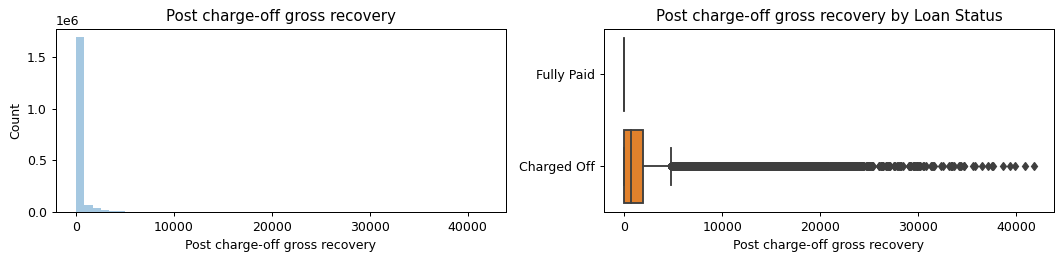

In [691]:
plot_var('recoveries', 'Post charge-off gross recovery', continuous=True)

In [692]:
# We drop recoveries because it happens after charge-off

loans_df.drop('recoveries', axis=1, inplace=True)

### 1.37 collection_recovery_fee

In [693]:
loans_df['collection_recovery_fee'].describe()

count    1.860331e+06
mean     4.570961e+01
std      1.854800e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      7.524585e+03
Name: collection_recovery_fee, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


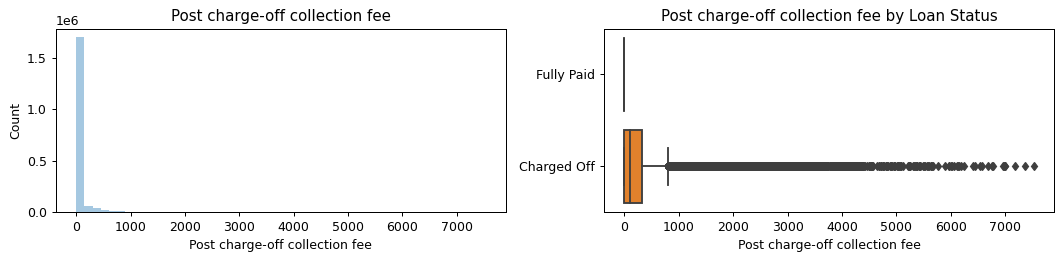

In [694]:
plot_var('collection_recovery_fee', 'Post charge-off collection fee', continuous=True)

In [695]:
# We drop collection recovery fee because it happens after charge-off

loans_df.drop('collection_recovery_fee', axis=1, inplace=True)

### 1.38 last_pymnt_d

In [696]:
loans_df['last_pymnt_d'].sample(5)

1524494    Oct-2019
96872      Sep-2016
2234339    Feb-2018
384512     May-2019
2262930    Oct-2016
Name: last_pymnt_d, dtype: object

In [697]:
# Change the date to a number

loans_df['last_pymnt_d'] = loans_df['last_pymnt_d'].apply(lambda x: int(str(datetime.datetime.strptime(x, "%b-%Y")).split("-")[0])*12 + int(str(datetime.datetime.strptime(x, "%b-%Y")).split("-")[1]) if x is not np.nan else x)

### 1.39 last_pymnt_amnt

In [698]:
loans_df['last_pymnt_amnt'].describe()

count    1.860331e+06
mean     5.214104e+03
std      7.088842e+03
min     -2.000000e+03
25%      3.726200e+02
50%      1.645680e+03
75%      7.841215e+03
max      4.219205e+04
Name: last_pymnt_amnt, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


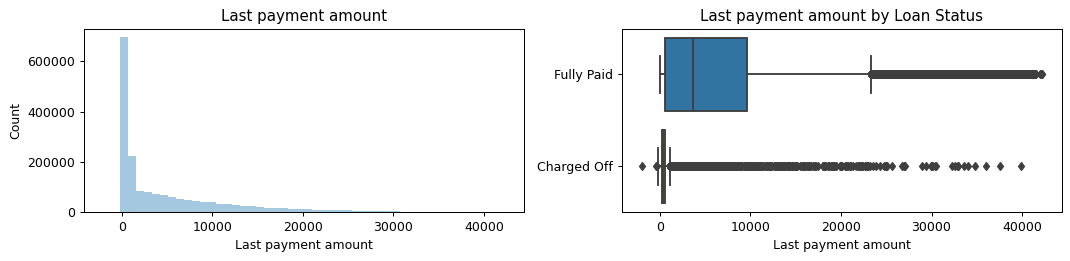

In [699]:
plot_var('last_pymnt_amnt', 'Last payment amount', continuous=True)

### 1.40 last_credit_pull_d

In [700]:
loans_df['last_credit_pull_d'].sample(5)

293454     May-2018
2640887    May-2020
443941     May-2020
2665723    Feb-2020
604097     Apr-2020
Name: last_credit_pull_d, dtype: object

In [701]:
# Change the date to a number

loans_df['last_credit_pull_d'] = loans_df['last_credit_pull_d'].apply(lambda x: int(str(datetime.datetime.strptime(x, "%b-%Y")).split("-")[0])*12 + int(str(datetime.datetime.strptime(x, "%b-%Y")).split("-")[1]) if x is not np.nan else x)


### 1.41 last_fico_range_high, last_fico_range_low

In [702]:
loans_df[['last_fico_range_low', 'last_fico_range_high']].describe()

,last_fico_range_low,last_fico_range_high
count,1.860331e+06,1.860331e+06
mean,6.619026e+02,6.789898e+02
std,1.334942e+02,8.248086e+01
min,0.000000e+00,0.000000e+00
25%,6.250000e+02,6.290000e+02
50%,6.900000e+02,6.940000e+02
75%,7.350000e+02,7.390000e+02
max,8.450000e+02,8.500000e+02


In [703]:
# We only need to keep one of the FICO scores. We take the average of the two and call it last_fico_score

loans_df['last_fico_score'] = 0.5*loans_df['last_fico_range_low'] + 0.5*loans_df['last_fico_range_high']

In [704]:
loans_df.drop(['last_fico_range_high', 'last_fico_range_low'], axis=1, inplace=True)

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


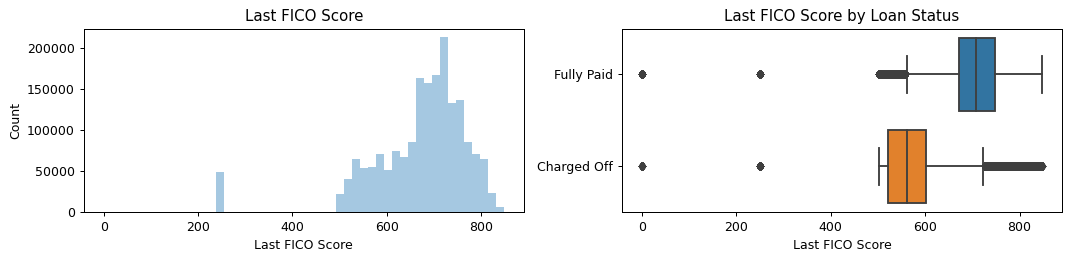

In [705]:
plot_var('last_fico_score', 'Last FICO Score', continuous=True)

### 1.42 collections_12_mths_ex_med

In [706]:
loans_df['collections_12_mths_ex_med'].describe()

count    1.860275e+06
mean     1.787800e-02
std      1.497260e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.000000e+01
Name: collections_12_mths_ex_med, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


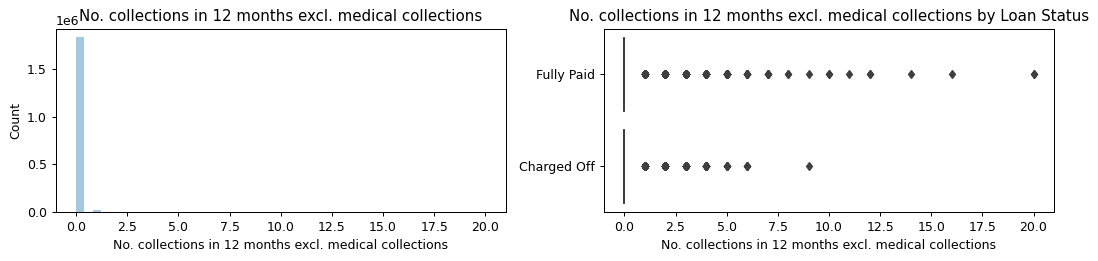

In [707]:
plot_var('collections_12_mths_ex_med', 'No. collections in 12 months excl. medical collections', continuous=True)

### 1.43 policy_code

In [708]:
loans_df['policy_code'].describe()

count    1860331.0
mean           1.0
std            0.0
min            1.0
25%            1.0
50%            1.0
75%            1.0
max            1.0
Name: policy_code, dtype: float64

In [709]:
loans_df.drop('policy_code', axis=1, inplace=True)

### 1.44 application_type

In [710]:
loans_df['application_type'].value_counts()

Individual    1790838
Joint App       69493
Name: application_type, dtype: int64

In [711]:
loans_df.groupby('application_type')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

application_type
Individual    0.192892
Joint App     0.246197
Name: loan_status, dtype: float64

### 1.45 acc_now_delinq

In [712]:
loans_df['acc_now_delinq'].describe()

count    1.860331e+06
mean     4.575530e-03
std      7.311535e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.400000e+01
Name: acc_now_delinq, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


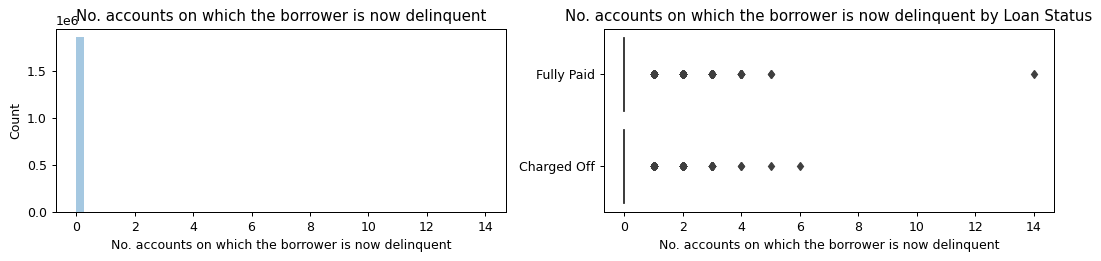

In [713]:
plot_var('acc_now_delinq', 'No. accounts on which the borrower is now delinquent', continuous=True)

### 1.46 tot_coll_amt

In [714]:
loans_df['tot_coll_amt'].describe()

count    1.792804e+06
mean     2.406589e+02
std      9.385688e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.152545e+06
Name: tot_coll_amt, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


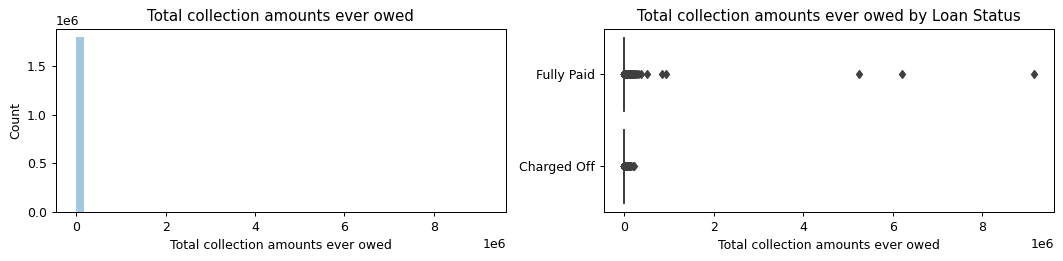

In [715]:
plot_var('tot_coll_amt', 'Total collection amounts ever owed', continuous=True)

### 1.47 tot_cur_bal

In [716]:
loans_df['tot_cur_bal'].describe()

count    1.792804e+06
mean     1.423811e+05
std      1.597166e+05
min      0.000000e+00
25%      2.928700e+04
50%      8.021350e+04
75%      2.129060e+05
max      8.524709e+06
Name: tot_cur_bal, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


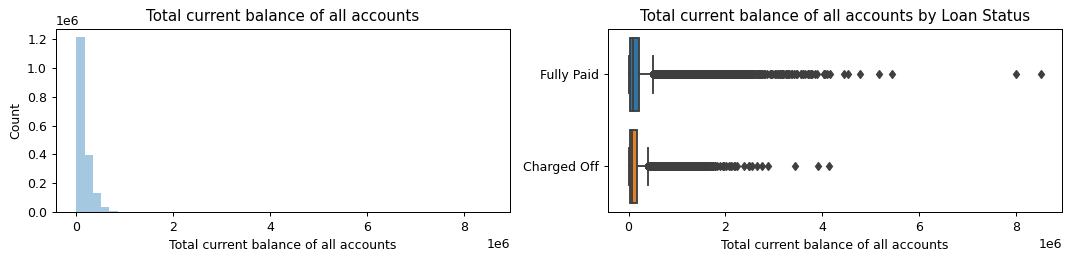

In [717]:
plot_var('tot_cur_bal', 'Total current balance of all accounts', continuous=True)

### 1.48 open_acc_6m

In [718]:
loans_df['open_acc_6m'].describe()

count    1.013907e+06
mean     9.990778e-01
std      1.179387e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      1.800000e+01
Name: open_acc_6m, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


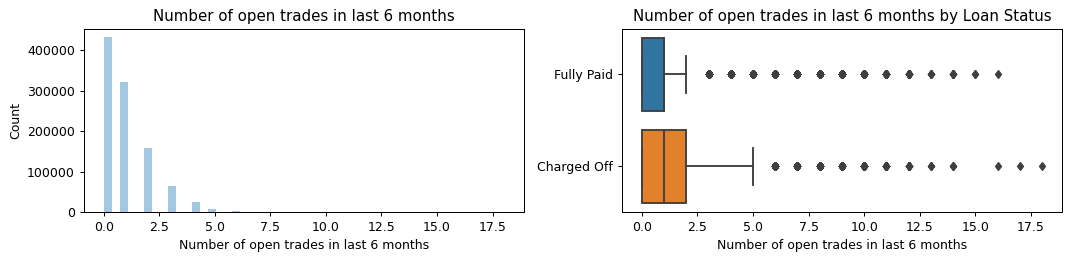

In [719]:
plot_var('open_acc_6m', 'Number of open trades in last 6 months', continuous=True)

### 1.49 open_act_il

In [720]:
loans_df['open_act_il'].describe()

count    1.013908e+06
mean     2.787363e+00
std      2.993414e+00
min      0.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      3.000000e+00
max      5.700000e+01
Name: open_act_il, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


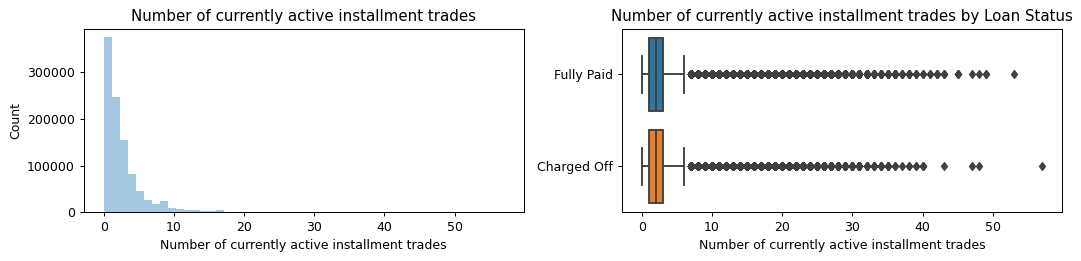

In [721]:
plot_var('open_act_il', 'Number of currently active installment trades', continuous=True)

### 1.50 open_il_12m, open_il_24m

In [722]:
loans_df['open_il_12m'].describe()

count    1.013908e+06
mean     7.390434e-01
std      9.687371e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      2.500000e+01
Name: open_il_12m, dtype: float64

In [723]:
loans_df['open_il_24m'].describe()

count    1.013908e+06
mean     1.676167e+00
std      1.642935e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      5.100000e+01
Name: open_il_24m, dtype: float64

In [724]:
## Just keep the 24 month variable

loans_df.drop('open_il_12m', axis=1, inplace=True)

### 1.51 total_bal_il

In [725]:
loans_df['total_bal_il'].describe()

count    1.013908e+06
mean     3.580632e+04
std      4.373605e+04
min      0.000000e+00
25%      9.135000e+03
50%      2.364100e+04
75%      4.654400e+04
max      1.711009e+06
Name: total_bal_il, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


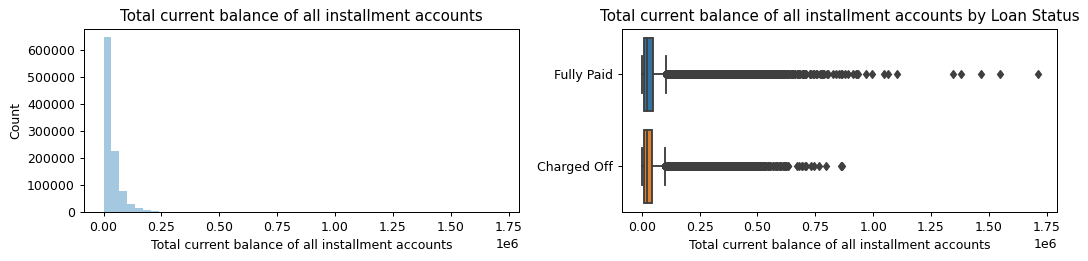

In [726]:
plot_var('total_bal_il', 'Total current balance of all installment accounts', continuous=True)

### 1.52 open_rv_12m, open_rv_24m

In [727]:
loans_df['open_rv_12m'].describe()

count    1.013908e+06
mean     1.357091e+00
std      1.541694e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.800000e+01
Name: open_rv_12m, dtype: float64

In [728]:
loans_df['open_rv_24m'].describe()

count    1.013908e+06
mean     2.869238e+00
std      2.648789e+00
min      0.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      4.000000e+00
max      6.000000e+01
Name: open_rv_24m, dtype: float64

In [729]:
## Just keep the 24 month variable

loans_df.drop('open_rv_12m', axis=1, inplace=True)

### 1.53 max_bal_bc

In [730]:
loans_df['max_bal_bc'].describe()

count    1.013908e+06
mean     5.605745e+03
std      5.632661e+03
min      0.000000e+00
25%      2.179000e+03
50%      4.244000e+03
75%      7.314000e+03
max      1.170668e+06
Name: max_bal_bc, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


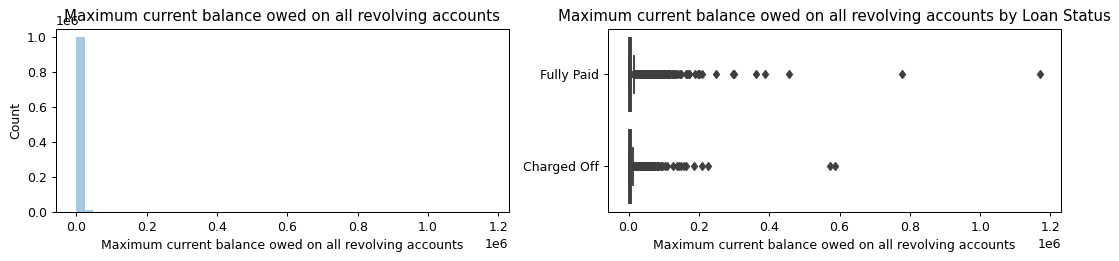

In [731]:
plot_var('max_bal_bc', 'Maximum current balance owed on all revolving accounts', continuous=True)

### 1.54 all_util

In [732]:
loans_df['all_util'].describe()

count    1.013769e+06
mean     5.722908e+01
std      2.104921e+01
min      0.000000e+00
25%      4.300000e+01
50%      5.800000e+01
75%      7.200000e+01
max      2.040000e+02
Name: all_util, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


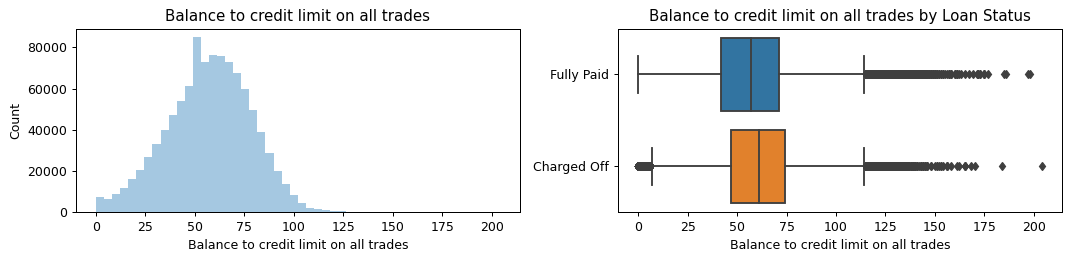

In [733]:
plot_var('all_util', 'Balance to credit limit on all trades', continuous=True)

### 1.55 total_rev_hi_lim

In [734]:
loans_df['total_rev_hi_lim'].describe()

count    1.792804e+06
mean     3.382443e+04
std      3.658255e+04
min      0.000000e+00
25%      1.440000e+04
50%      2.480000e+04
75%      4.210000e+04
max      9.999999e+06
Name: total_rev_hi_lim, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


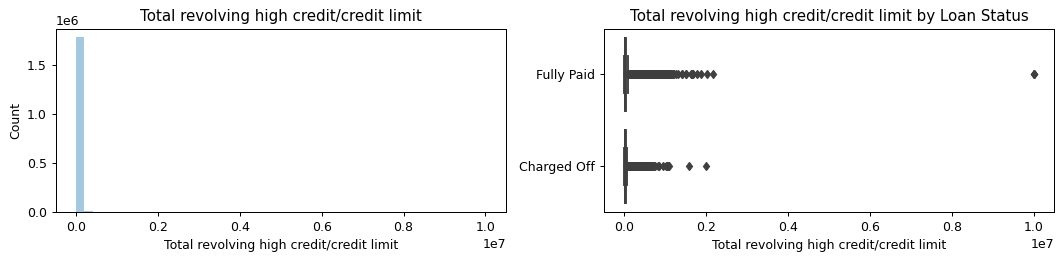

In [735]:
plot_var('total_rev_hi_lim', 'Total revolving high credit/credit limit', continuous=True)

### 1.56 inq_fi

In [736]:
loans_df['inq_fi'].describe()

count    1.013908e+06
mean     1.082603e+00
std      1.552414e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      4.800000e+01
Name: inq_fi, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


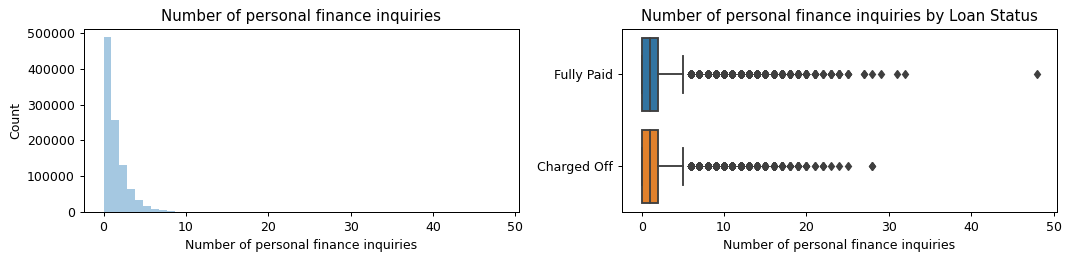

In [737]:
plot_var('inq_fi', 'Number of personal finance inquiries', continuous=True)

### 1.57 total_cu_tl

In [738]:
loans_df['total_cu_tl'].describe()

count    1.013907e+06
mean     1.557800e+00
std      2.771790e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.000000e+00
max      7.900000e+01
Name: total_cu_tl, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


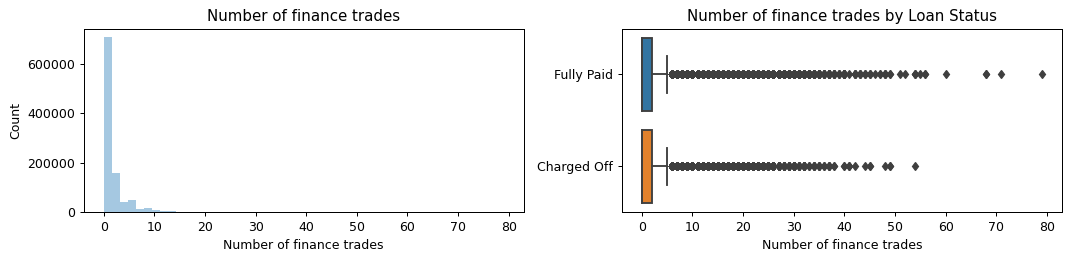

In [739]:
plot_var('total_cu_tl', 'Number of finance trades', continuous=True)

### 1.58 inq_last_12m

In [740]:
loans_df['inq_last_12m'].describe()

count    1.013907e+06
mean     2.185089e+00
std      2.470289e+00
min      0.000000e+00
25%      0.000000e+00
50%      2.000000e+00
75%      3.000000e+00
max      6.700000e+01
Name: inq_last_12m, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


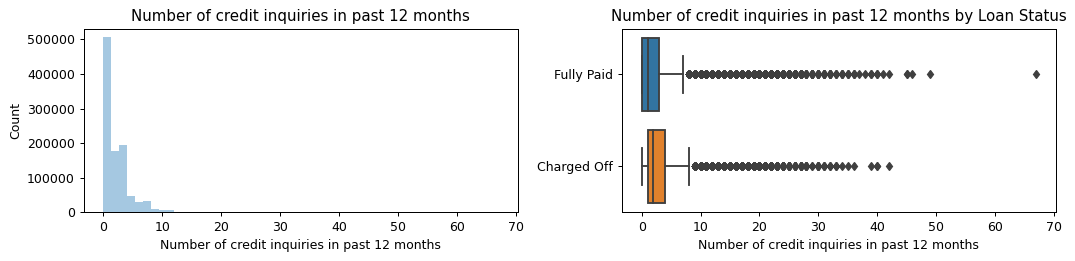

In [741]:
plot_var('inq_last_12m', 'Number of credit inquiries in past 12 months', continuous=True)

### 1.59 acc_open_past_24mths

In [742]:
loans_df['acc_open_past_24mths'].describe()

count    1.813050e+06
mean     4.652179e+00
std      3.196444e+00
min      0.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      6.000000e+00
max      6.400000e+01
Name: acc_open_past_24mths, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


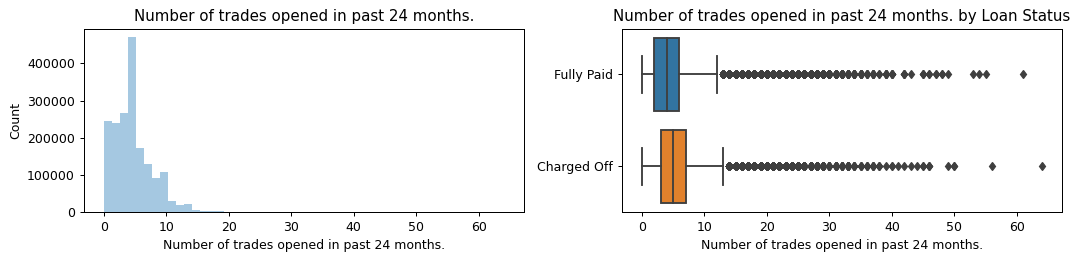

In [743]:
plot_var('acc_open_past_24mths', 'Number of trades opened in past 24 months.', continuous=True)

### 1.60 avg_cur_bal

In [744]:
loans_df['avg_cur_bal'].describe()

count    1.792759e+06
mean     1.358854e+04
std      1.649626e+04
min      0.000000e+00
25%      3.093000e+03
50%      7.408000e+03
75%      1.883700e+04
max      9.580840e+05
Name: avg_cur_bal, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


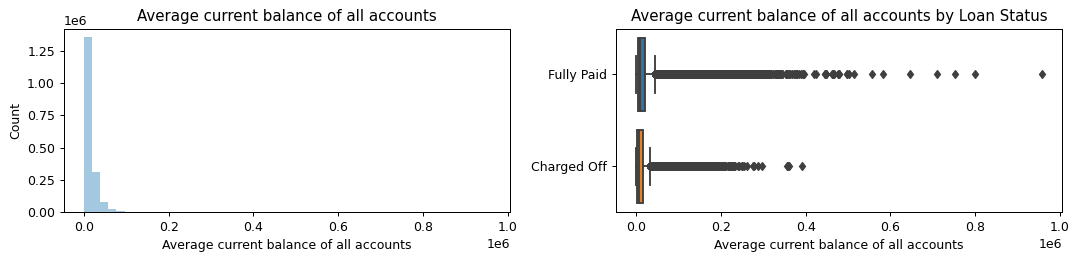

In [745]:
plot_var('avg_cur_bal', 'Average current balance of all accounts', continuous=True)

### 1.61 bc_open_to_buy

In [746]:
loans_df['bc_open_to_buy'].describe()

count    1.792591e+06
mean     1.106602e+04
std      1.635447e+04
min      0.000000e+00
25%      1.631000e+03
50%      5.196000e+03
75%      1.365000e+04
max      6.059960e+05
Name: bc_open_to_buy, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


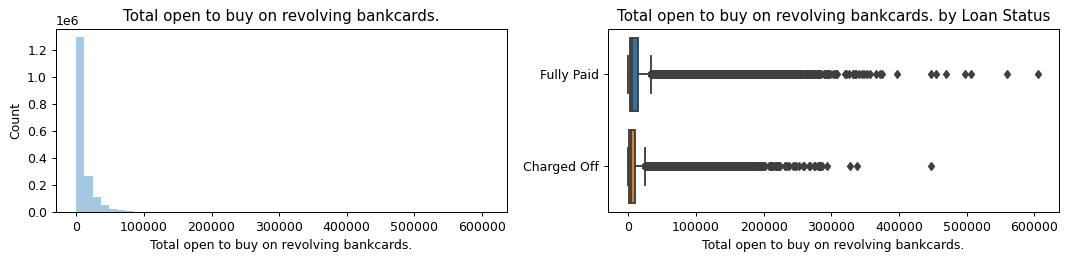

In [747]:
plot_var('bc_open_to_buy', 'Total open to buy on revolving bankcards.', continuous=True)

### 1.62 bc_util

In [748]:
loans_df['bc_util'].describe()

count    1.791576e+06
mean     5.815780e+01
std      2.871167e+01
min      0.000000e+00
25%      3.560000e+01
50%      6.080000e+01
75%      8.350000e+01
max      3.396000e+02
Name: bc_util, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


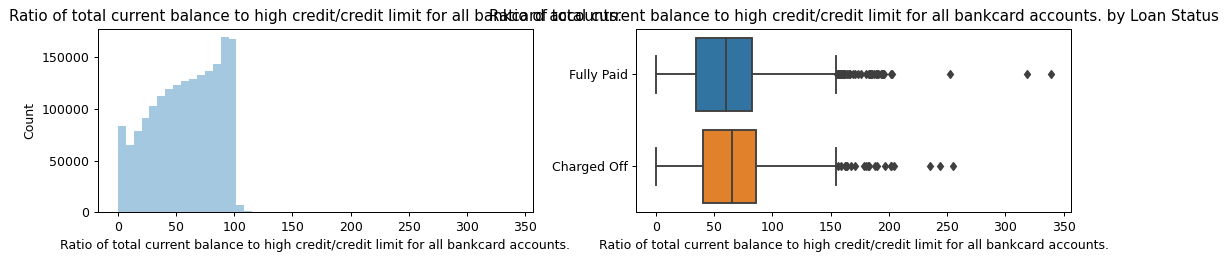

In [749]:
plot_var('bc_util', 'Ratio of total current balance to high credit/credit limit for all bankcard accounts.', continuous=True)

### 1.63 chargeoff_within_12_mths

In [750]:
loans_df['chargeoff_within_12_mths'].describe()

count    1.860275e+06
mean     8.822352e-03
std      1.079128e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+01
Name: chargeoff_within_12_mths, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


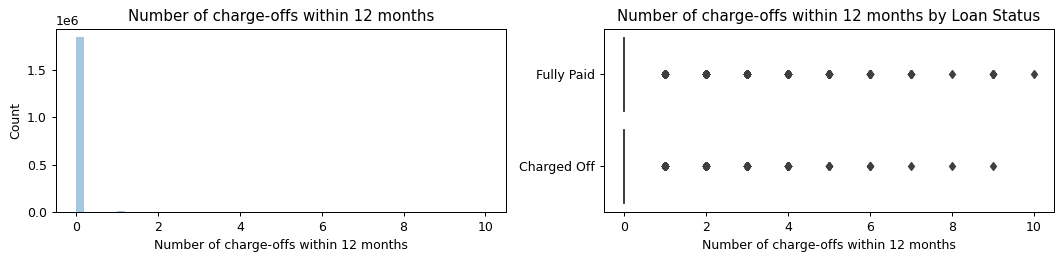

In [751]:
plot_var('chargeoff_within_12_mths', 'Number of charge-offs within 12 months', continuous=True)

### 1.64 delinq_amnt

In [752]:
loans_df['delinq_amnt'].describe()

count    1.860331e+06
mean     1.351186e+01
std      7.569532e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.499250e+05
Name: delinq_amnt, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


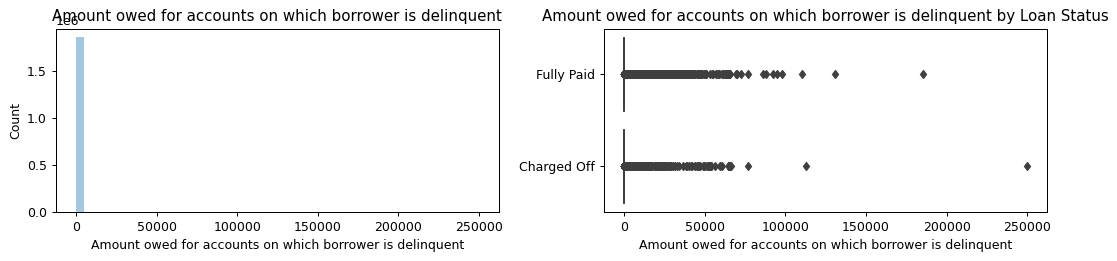

In [753]:
plot_var('delinq_amnt', 'Amount owed for accounts on which borrower is delinquent', continuous=True)

### 1.65 mo_sin_old_il_acct

In [754]:
loans_df['mo_sin_old_il_acct'].describe()

count    1.739201e+06
mean     1.255278e+02
std      5.291141e+01
min      0.000000e+00
25%      9.600000e+01
50%      1.290000e+02
75%      1.530000e+02
max      9.990000e+02
Name: mo_sin_old_il_acct, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


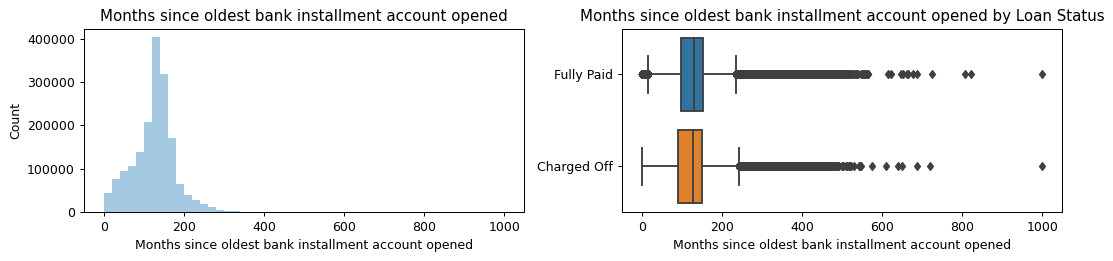

In [755]:
plot_var('mo_sin_old_il_acct', 'Months since oldest bank installment account opened', continuous=True)

### 1.66 mo_sin_old_rev_tl_op

In [756]:
loans_df['mo_sin_old_rev_tl_op'].describe()

count    1.792803e+06
mean     1.806286e+02
std      9.582080e+01
min      1.000000e+00
25%      1.160000e+02
50%      1.630000e+02
75%      2.300000e+02
max      9.090000e+02
Name: mo_sin_old_rev_tl_op, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


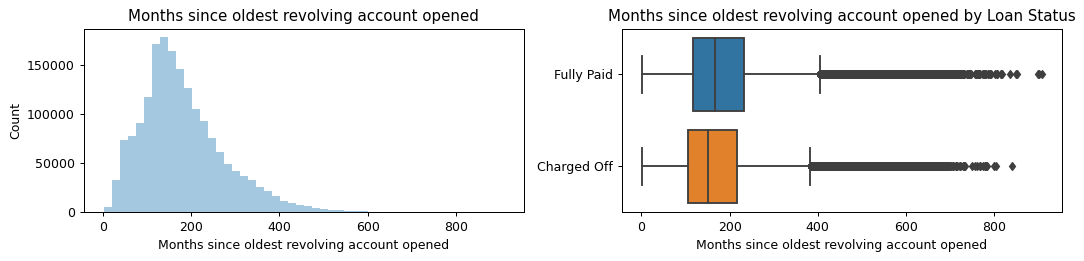

In [757]:
plot_var('mo_sin_old_rev_tl_op', 'Months since oldest revolving account opened', continuous=True)

### 1.67 mo_sin_rcnt_rev_tl_op

In [758]:
loans_df['mo_sin_rcnt_rev_tl_op'].describe()

count    1.792803e+06
mean     1.350344e+01
std      1.683659e+01
min      0.000000e+00
25%      4.000000e+00
50%      8.000000e+00
75%      1.600000e+01
max      4.380000e+02
Name: mo_sin_rcnt_rev_tl_op, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


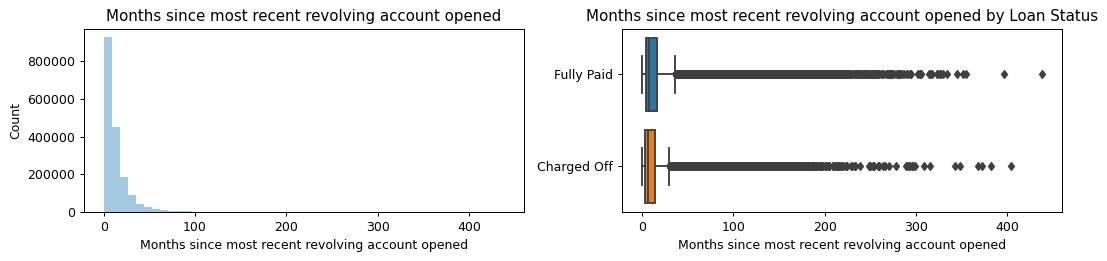

In [759]:
plot_var('mo_sin_rcnt_rev_tl_op', 'Months since most recent revolving account opened', continuous=True)

### 1.68 mo_sin_rcnt_tl

In [760]:
loans_df['mo_sin_rcnt_tl'].describe()

count    1.792804e+06
mean     7.989971e+00
std      8.850508e+00
min      0.000000e+00
25%      3.000000e+00
50%      6.000000e+00
75%      1.000000e+01
max      3.820000e+02
Name: mo_sin_rcnt_tl, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


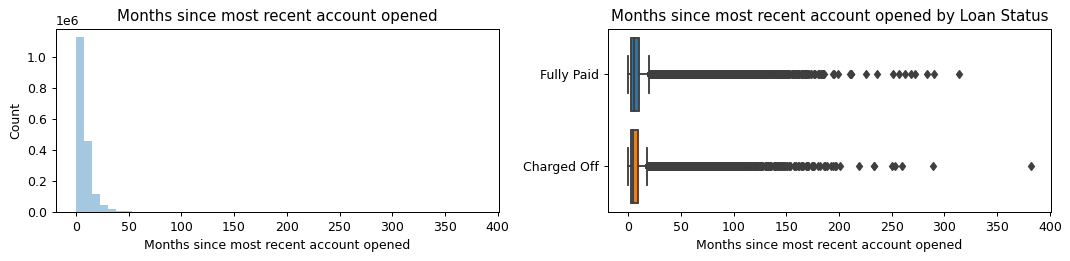

In [761]:
plot_var('mo_sin_rcnt_tl', 'Months since most recent account opened', continuous=True)

### 1.69 mort_acc

In [762]:
loans_df['mort_acc'].describe()

count    1.813050e+06
mean     1.606560e+00
std      1.945149e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      6.100000e+01
Name: mort_acc, dtype: float64

In [763]:
loans_df['mort_acc'].value_counts().head(10)

0.0    747953
1.0    319708
2.0    266554
3.0    191975
4.0    127349
5.0     75161
6.0     41412
7.0     21061
8.0     10418
9.0      5277
Name: mort_acc, dtype: int64

In [764]:
total_acc_avg = loans_df.groupby('total_acc').mean()['mort_acc'].fillna(0)

def fill_mort_acc(total_acc,mort_acc):
    '''
    Accepts the total_acc and mort_acc values for the row.
    Checks if the mort_acc is NaN , if so, it returns the avg mort_acc value
    for the corresponding total_acc value for that row.
    
    total_acc_avg here should be a Series or dictionary containing the mapping of the
    groupby averages of mort_acc per total_acc values.
    '''
    if mort_acc>=0:
        return total_acc_avg[total_acc]
    else:
        return mort_acc

In [765]:
loans_df['mort_acc'] = loans_df.apply(lambda x: fill_mort_acc(x['total_acc'], x['mort_acc']), axis=1)

In [766]:
loans_df.groupby('loan_status')['mort_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,355662.0,1.575212,0.762083,0.0,0.929475,1.573109,2.198709,9.285714
Fully Paid,1457388.0,1.614210,0.751708,0.0,1.015993,1.645710,2.266204,11.000000


### 1.70 mths_since_recent_bc

In [767]:
loans_df['mths_since_recent_bc'].describe()

count    1.793886e+06
mean     2.414714e+01
std      3.134440e+01
min      0.000000e+00
25%      6.000000e+00
50%      1.300000e+01
75%      2.900000e+01
max      6.560000e+02
Name: mths_since_recent_bc, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


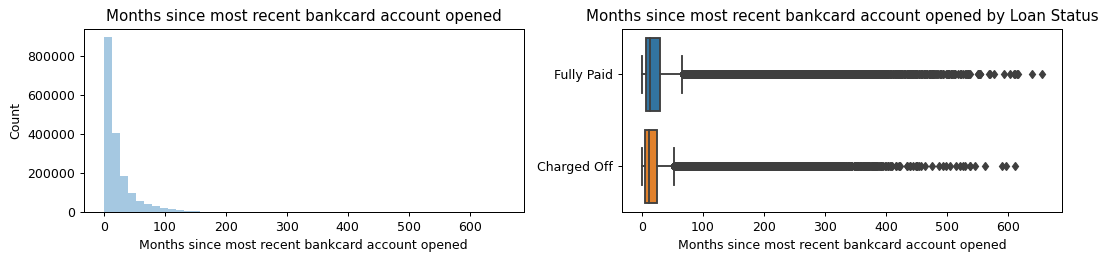

In [768]:
plot_var('mths_since_recent_bc', 'Months since most recent bankcard account opened', continuous=True)

### 1.71 mths_since_recent_inq

In [769]:
loans_df['mths_since_recent_inq'].describe()

count    1.628871e+06
mean     6.833788e+00
std      5.886143e+00
min      0.000000e+00
25%      2.000000e+00
50%      5.000000e+00
75%      1.000000e+01
max      2.500000e+01
Name: mths_since_recent_inq, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


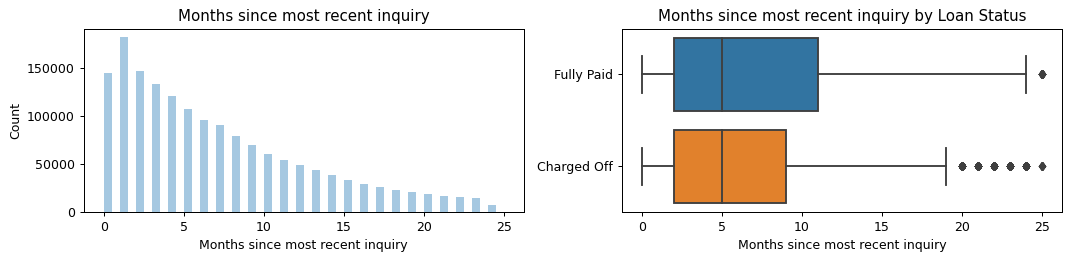

In [770]:
plot_var('mths_since_recent_inq', 'Months since most recent inquiry', continuous=True)

### 1.72 num_accts_ever_120_pd

In [771]:
loans_df['num_accts_ever_120_pd'].describe()

count    1.792804e+06
mean     5.096430e-01
std      1.353333e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      5.100000e+01
Name: num_accts_ever_120_pd, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


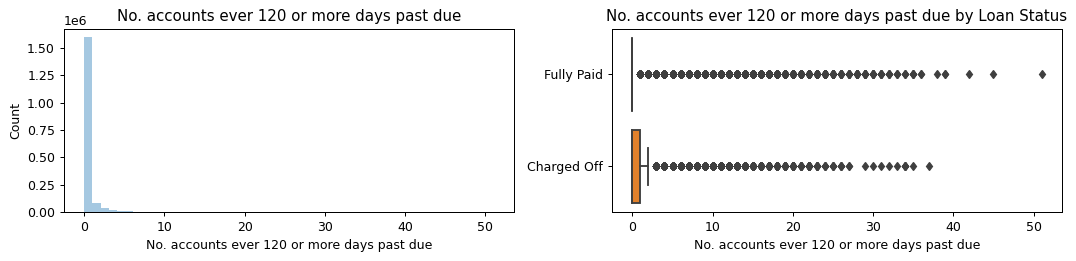

In [772]:
plot_var('num_accts_ever_120_pd', 'No. accounts ever 120 or more days past due', continuous=True)

### 1.73 num_actv_bc_tl

In [773]:
loans_df['num_actv_bc_tl'].describe()

count    1.792804e+06
mean     3.634729e+00
std      2.283976e+00
min      0.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      5.000000e+00
max      5.000000e+01
Name: num_actv_bc_tl, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


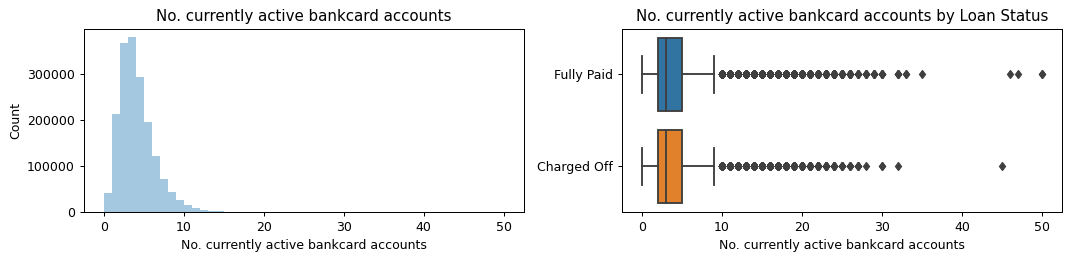

In [774]:
plot_var('num_actv_bc_tl', 'No. currently active bankcard accounts', continuous=True)

### 1.74 num_actv_rev_tl

In [775]:
loans_df['num_actv_rev_tl'].describe()

count    1.792804e+06
mean     5.593915e+00
std      3.337368e+00
min      0.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      7.000000e+00
max      7.200000e+01
Name: num_actv_rev_tl, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


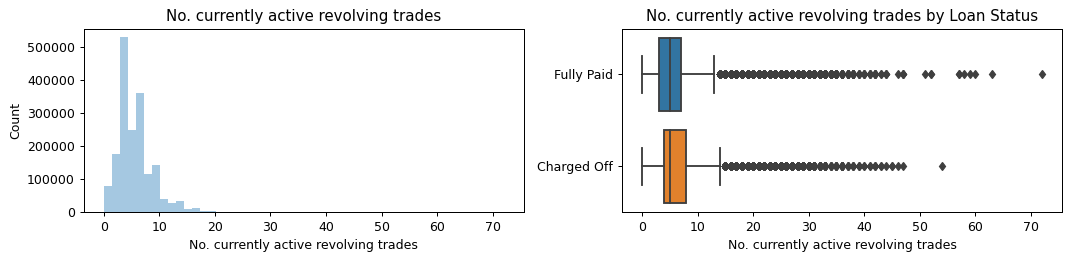

In [776]:
plot_var('num_actv_rev_tl', 'No. currently active revolving trades', continuous=True)

### 1.75 num_bc_sats

In [777]:
loans_df['num_bc_sats'].describe()

count    1.804490e+06
mean     4.751566e+00
std      3.006162e+00
min      0.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      6.000000e+00
max      6.300000e+01
Name: num_bc_sats, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


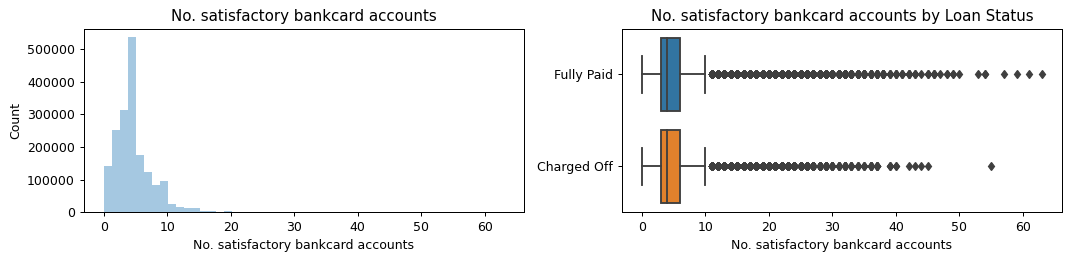

In [778]:
plot_var('num_bc_sats', 'No. satisfactory bankcard accounts', continuous=True)

### 1.76 num_bc_tl

In [779]:
loans_df['num_bc_tl'].describe()

count    1.792804e+06
mean     7.877405e+00
std      4.753367e+00
min      0.000000e+00
25%      4.000000e+00
50%      7.000000e+00
75%      1.000000e+01
max      8.900000e+01
Name: num_bc_tl, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


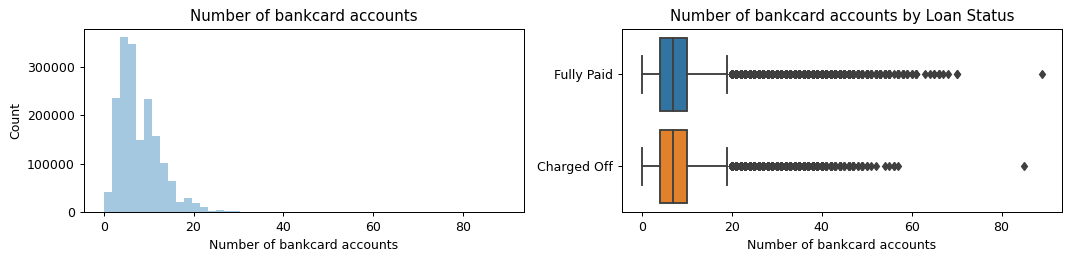

In [780]:
plot_var('num_bc_tl', 'Number of bankcard accounts', continuous=True)

### 1.77 num_il_tl

In [781]:
loans_df['num_il_tl'].describe()

count    1.792804e+06
mean     8.556365e+00
std      7.412269e+00
min      0.000000e+00
25%      3.000000e+00
50%      7.000000e+00
75%      1.100000e+01
max      1.590000e+02
Name: num_il_tl, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


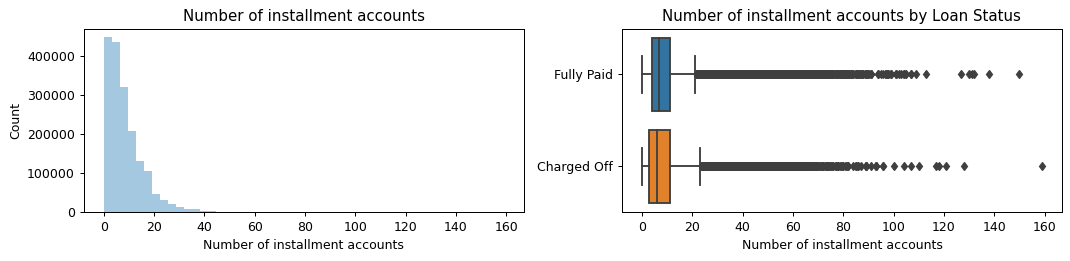

In [782]:
plot_var('num_il_tl', 'Number of installment accounts', continuous=True)

### 1.78 num_op_rev_tl

In [783]:
loans_df['num_op_rev_tl'].describe()

count    1.792804e+06
mean     8.249852e+00
std      4.637602e+00
min      0.000000e+00
25%      5.000000e+00
50%      7.000000e+00
75%      1.000000e+01
max      8.300000e+01
Name: num_op_rev_tl, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


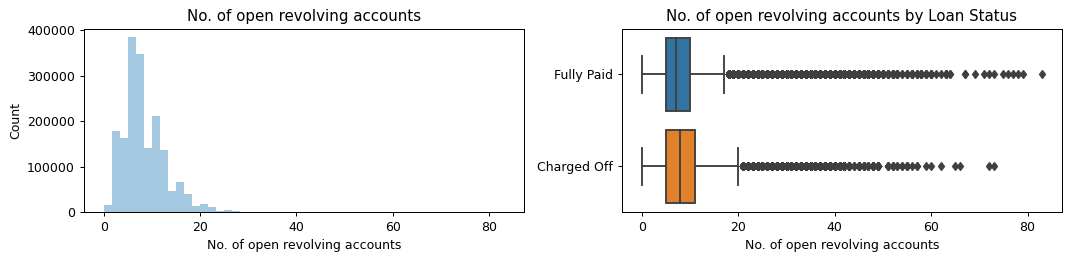

In [784]:
plot_var('num_op_rev_tl', 'No. of open revolving accounts', continuous=True)

### 1.79 num_rev_accts

In [785]:
loans_df['num_rev_accts'].describe()

count    1.792803e+06
mean     1.426274e+01
std      8.098850e+00
min      0.000000e+00
25%      8.000000e+00
50%      1.300000e+01
75%      1.800000e+01
max      1.280000e+02
Name: num_rev_accts, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


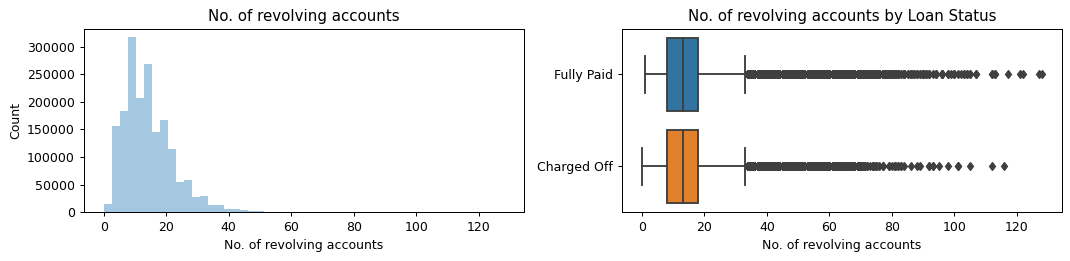

In [786]:
plot_var('num_rev_accts', 'No. of revolving accounts', continuous=True)

### 1.80 num_rev_tl_bal_gt_0

In [787]:
loans_df['num_rev_tl_bal_gt_0'].describe()

count    1.792804e+06
mean     5.542162e+00
std      3.249589e+00
min      0.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      7.000000e+00
max      6.500000e+01
Name: num_rev_tl_bal_gt_0, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


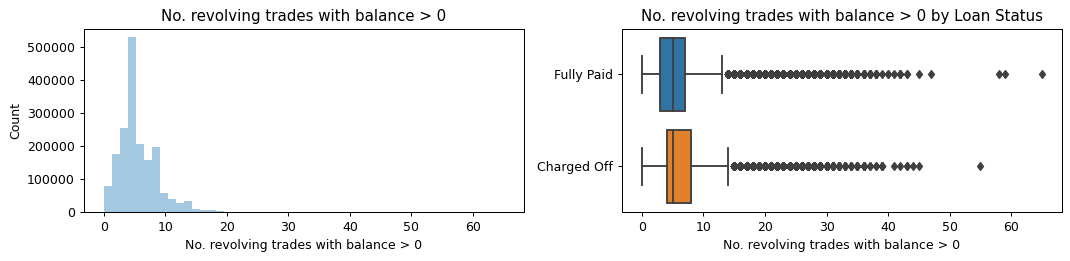

In [788]:
plot_var('num_rev_tl_bal_gt_0', 'No. revolving trades with balance > 0', continuous=True)

### 1.81 num_sats

In [789]:
loans_df['num_sats'].describe()

count    1.804490e+06
mean     1.162916e+01
std      5.580934e+00
min      0.000000e+00
25%      8.000000e+00
50%      1.100000e+01
75%      1.400000e+01
max      9.000000e+01
Name: num_sats, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


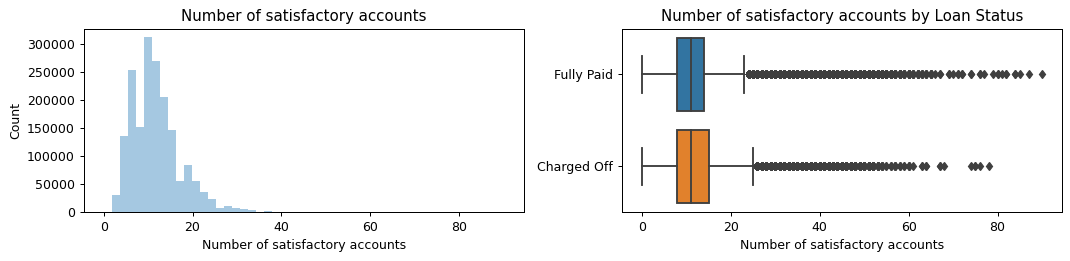

In [790]:
plot_var('num_sats', 'Number of satisfactory accounts', continuous=True)

### 1.82 num_tl_120dpd_2m, num_tl_30dpd

In [791]:
loans_df['num_tl_120dpd_2m'].describe()

count    1.724714e+06
mean     7.178002e-04
std      2.837985e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      6.000000e+00
Name: num_tl_120dpd_2m, dtype: float64

In [792]:
loans_df['num_tl_30dpd'].describe()

count    1.792804e+06
mean     3.092920e-03
std      5.905246e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.000000e+00
Name: num_tl_30dpd, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


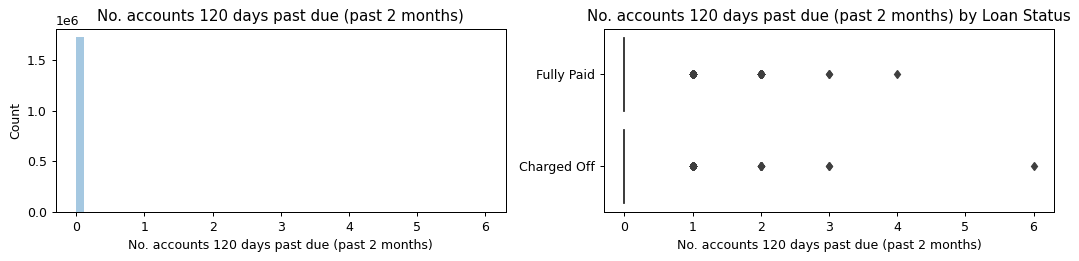

In [793]:
plot_var('num_tl_120dpd_2m', 'No. accounts 120 days past due (past 2 months)', continuous=True)

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


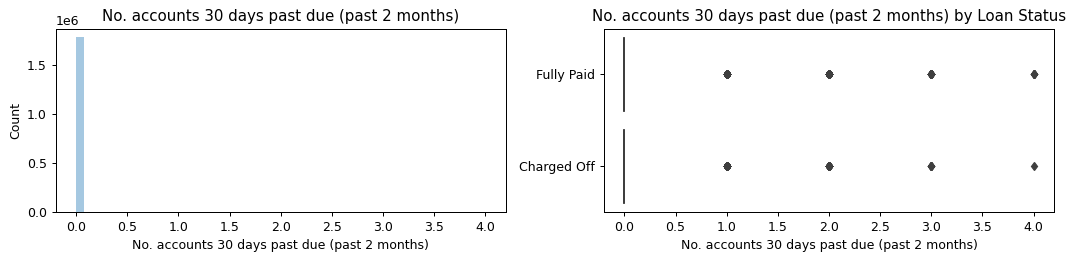

In [794]:
plot_var('num_tl_30dpd', 'No. accounts 30 days past due (past 2 months)', continuous=True)

### 1.83 num_tl_90g_dpd_24m

In [795]:
loans_df['num_tl_90g_dpd_24m'].describe()

count    1.792804e+06
mean     8.597872e-02
std      5.015067e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.200000e+01
Name: num_tl_90g_dpd_24m, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


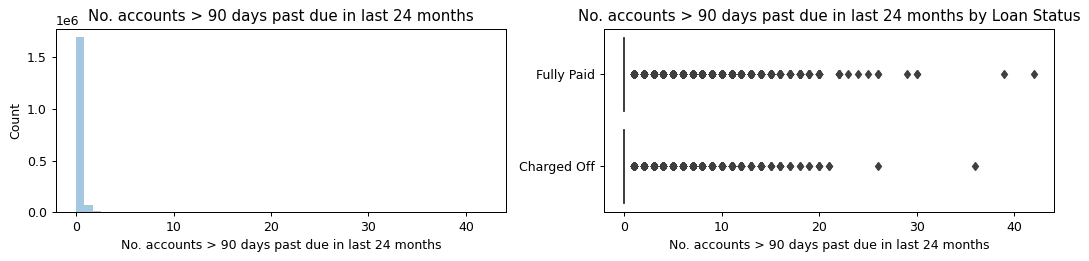

In [796]:
plot_var('num_tl_90g_dpd_24m', 'No. accounts > 90 days past due in last 24 months', continuous=True)

### 1.84 num_tl_op_past_12m

In [797]:
loans_df['num_tl_op_past_12m'].describe()

count    1.792804e+06
mean     2.153039e+00
std      1.853129e+00
min      0.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      3.000000e+00
max      3.200000e+01
Name: num_tl_op_past_12m, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


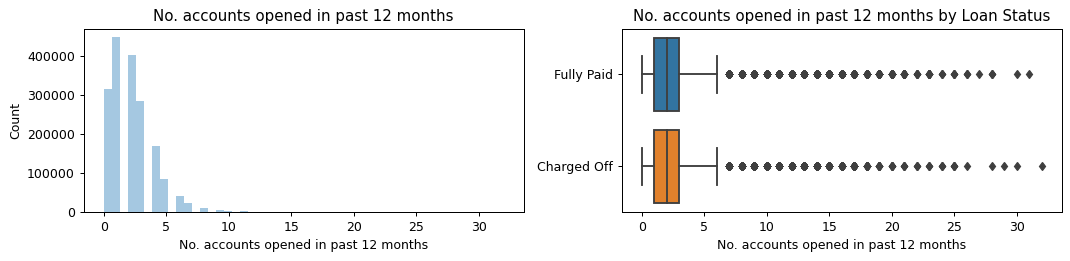

In [798]:
plot_var('num_tl_op_past_12m', 'No. accounts opened in past 12 months', continuous=True)

### 1.85 pct_tl_nvr_dlq

In [799]:
loans_df['pct_tl_nvr_dlq'].describe()

count    1.792650e+06
mean     9.413233e+01
std      8.914342e+00
min      0.000000e+00
25%      9.130000e+01
50%      9.860000e+01
75%      1.000000e+02
max      1.000000e+02
Name: pct_tl_nvr_dlq, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


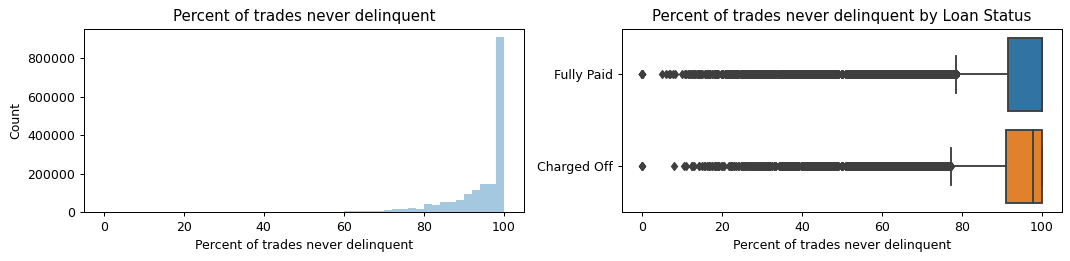

In [800]:
plot_var('pct_tl_nvr_dlq', 'Percent of trades never delinquent', continuous=True)

### 1.86 percent_bc_gt_75

In [801]:
loans_df['percent_bc_gt_75'].describe()

count    1.792151e+06
mean     4.301692e+01
std      3.618057e+01
min      0.000000e+00
25%      0.000000e+00
50%      4.000000e+01
75%      7.500000e+01
max      1.000000e+02
Name: percent_bc_gt_75, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


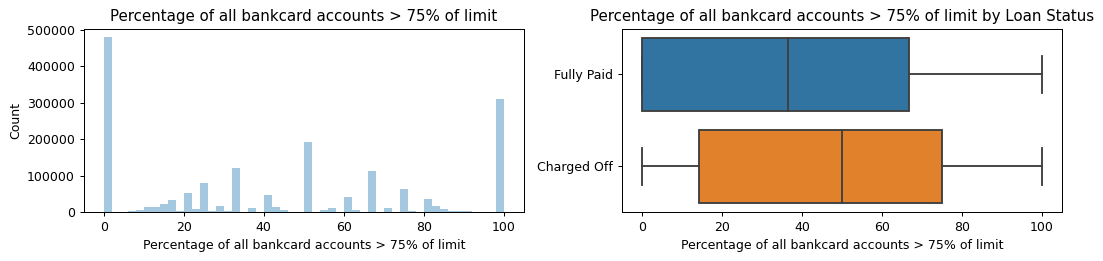

In [802]:
plot_var('percent_bc_gt_75', 'Percentage of all bankcard accounts > 75% of limit', continuous=True)

### 1.87 pub_rec_bankruptcies

In [803]:
loans_df['pub_rec_bankruptcies'].value_counts().sort_index()

0.0     1628840
1.0      218344
2.0        9723
3.0        1952
4.0         505
5.0         177
6.0          58
7.0          21
8.0           9
9.0           3
11.0          1
12.0          1
Name: pub_rec_bankruptcies, dtype: int64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


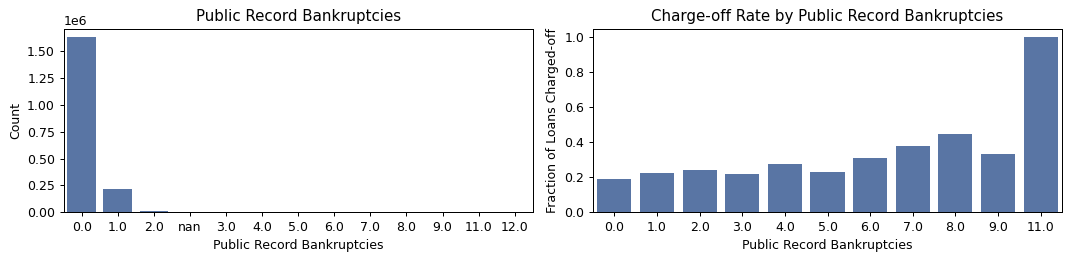

In [804]:
plot_var('pub_rec_bankruptcies', 'Public Record Bankruptcies', continuous=False)

### 1.88 tax_liens

In [805]:
loans_df['tax_liens'].describe()

count    1.860292e+06
mean     4.968037e-02
std      3.917770e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      8.500000e+01
Name: tax_liens, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


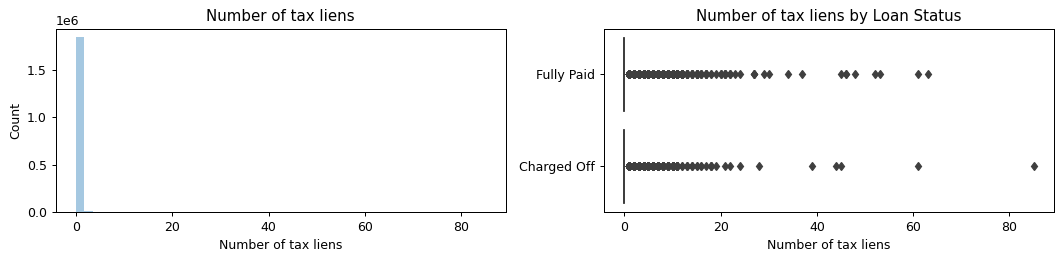

In [806]:
plot_var('tax_liens', 'Number of tax liens', continuous=True)

### 1.89 tot_hi_cred_lim

In [807]:
loans_df['tot_hi_cred_lim'].describe()

count    1.792804e+06
mean     1.771811e+05
std      1.805330e+05
min      0.000000e+00
25%      5.040000e+04
50%      1.140985e+05
75%      2.561790e+05
max      9.999999e+06
Name: tot_hi_cred_lim, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


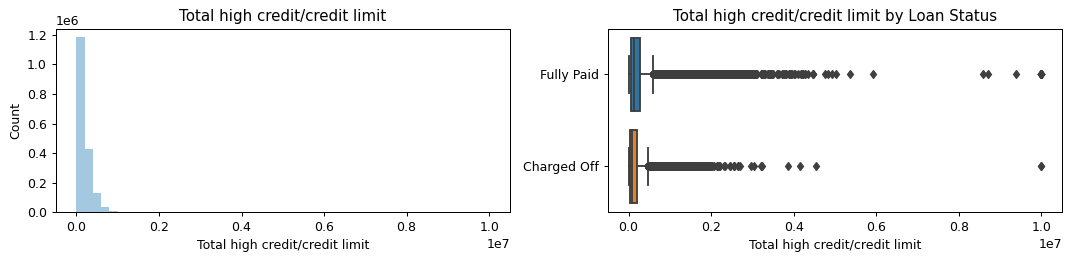

In [808]:
plot_var('tot_hi_cred_lim', 'Total high credit/credit limit', continuous=True)

### 1.90 total_bal_ex_mort

In [809]:
loans_df['total_bal_ex_mort'].describe()

count    1.813050e+06
mean     5.047443e+04
std      4.903623e+04
min      0.000000e+00
25%      2.086100e+04
50%      3.761500e+04
75%      6.362000e+04
max      3.408095e+06
Name: total_bal_ex_mort, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


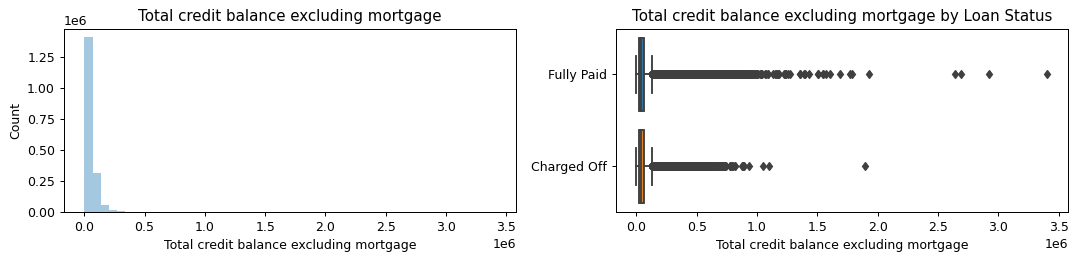

In [810]:
plot_var('total_bal_ex_mort', 'Total credit balance excluding mortgage', continuous=True)

### 1.91 total_bc_limit

In [811]:
loans_df['total_bc_limit'].describe()

count    1.813050e+06
mean     2.254080e+04
std      2.251148e+04
min      0.000000e+00
25%      8.000000e+03
50%      1.580000e+04
75%      2.940000e+04
max      1.569000e+06
Name: total_bc_limit, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


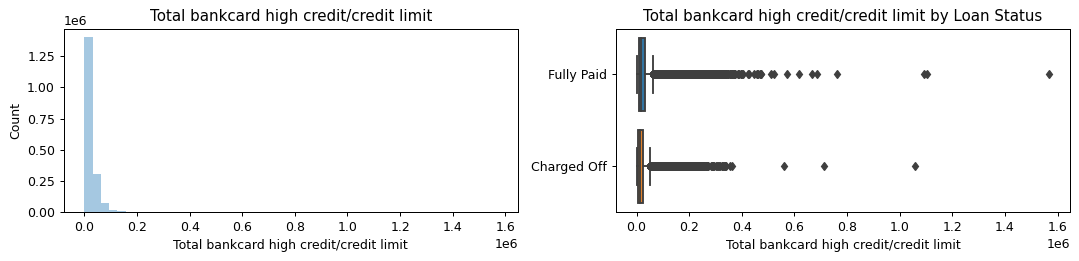

In [812]:
plot_var('total_bc_limit', 'Total bankcard high credit/credit limit', continuous=True)

### 1.92 total_il_high_credit_limit

In [813]:
loans_df['total_il_high_credit_limit'].describe()

count    1.792804e+06
mean     4.320236e+04
std      4.438071e+04
min      0.000000e+00
25%      1.500000e+04
50%      3.239900e+04
75%      5.805100e+04
max      2.101913e+06
Name: total_il_high_credit_limit, dtype: float64

/Users/gianluca/python_venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


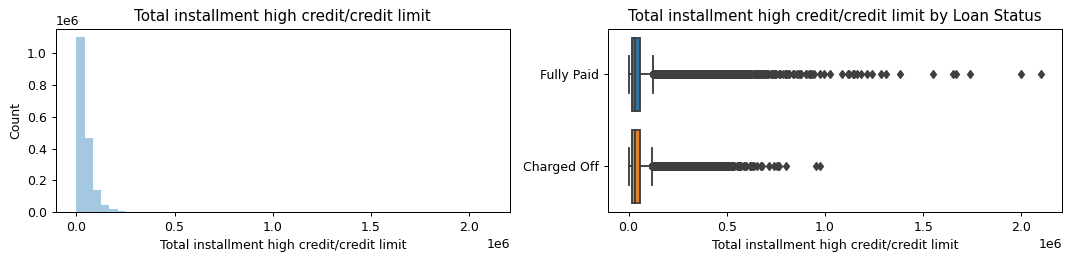

In [814]:
plot_var('total_il_high_credit_limit', 'Total installment high credit/credit limit', continuous=True)

### 1.93 hardship_flag

In [815]:
loans_df['hardship_flag'].describe()

count     1850977
unique          2
top             N
freq      1849344
Name: hardship_flag, dtype: object

In [816]:
loans_df['hardship_flag'].value_counts()

N    1849344
Y       1633
Name: hardship_flag, dtype: int64

### 1.94 debt_settlement_flag

In [817]:
loans_df['debt_settlement_flag'].describe()

count     1860331
unique          2
top             N
freq      1809170
Name: debt_settlement_flag, dtype: object

In [818]:
loans_df['debt_settlement_flag'].value_counts()

N    1809170
Y      51161
Name: debt_settlement_flag, dtype: int64

In [819]:
# Applies only after charge-off, so remove

loans_df.drop('debt_settlement_flag', axis=1, inplace=True)

## 2. Pre-processing 

In [820]:
# Convert loan status to 0/1 charge-off indicator

loans_df = loans_df.loc[loans_df['loan_status'].isin(['Fully Paid', 'Charged Off'])]

loans_df['charged_off'] = (loans_df['loan_status'] == 'Charged Off').apply(np.uint8)
loans_df.drop('loan_status', axis=1, inplace=True)

loans_df = loans_df.dropna().reset_index(drop=True)

In [825]:
# Create dummy variables

loans_df.shape

(827929, 86)

In [826]:
loans_df.head()

,Unnamed: 0,loan_amnt,term,int_rate,installment,sub_grade,home_ownership,verification_status,issue_d,purpose,...,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,log_annual_inc,fico_score,log_revol_bal,last_fico_score,charged_off
0,0,12000.0,36,7.97,375.88,A5,OWN,Source Verified,Sep-2017,debt_consolidation,...,57180.0,30502.0,15500.0,26180.0,N,4.623260,717.0,4.059109,692.0,0
1,6,10000.0,36,9.44,320.05,B1,MORTGAGE,Not Verified,Sep-2017,debt_consolidation,...,315034.0,216375.0,10500.0,175048.0,N,4.740371,697.0,3.856668,712.0,0
2,12,15000.0,36,13.59,509.69,C2,MORTGAGE,Source Verified,Sep-2017,medical,...,769704.0,297447.0,116700.0,221207.0,N,5.255275,682.0,5.030256,652.0,0
3,13,40000.0,60,7.97,810.49,A5,OWN,Verified,Sep-2017,home_improvement,...,413719.0,354714.0,48400.0,324919.0,N,5.301032,762.0,4.020320,507.0,1
4,14,18000.0,60,16.02,437.92,C5,RENT,Not Verified,Sep-2017,credit_card,...,91737.0,57941.0,51600.0,40137.0,N,5.096913,677.0,4.254886,762.0,0


In [822]:
missing_fractions = loans_df.isnull().mean().sort_values(ascending=False) # Fraction of data missing for each variable
print(missing_fractions[missing_fractions > 0]) # Print variables that are missing data

Series([], dtype: float64)


In [837]:
loans_df = pd.get_dummies(loans_df, columns=['sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'initial_list_status', 'application_type', 'hardship_flag'], drop_first=True)

In [838]:
loans_df.sample(5)

,Unnamed: 0,loan_amnt,term,int_rate,installment,issue_d,dti,delinq_2yrs,earliest_cr_line,fico_range_low,...,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w,application_type_Joint App,hardship_flag_Y
192719,91052,11200.0,36,14.07,383.18,Apr-2018,17.23,0.0,2013,740.0,...,0,0,0,0,0,0,0,1,0,0
532419,90643,12000.0,60,14.46,282.09,Apr-2016,21.50,0.0,2008,710.0,...,0,0,0,0,0,0,0,1,0,0
697222,7984,12000.0,36,11.39,395.09,Mar-2017,18.02,2.0,1990,710.0,...,0,0,0,0,0,0,0,1,0,0
531729,89789,8000.0,36,16.29,282.41,Apr-2016,26.65,3.0,2000,680.0,...,0,1,0,0,0,0,0,0,0,0
47870,94156,7000.0,36,11.99,232.47,Jul-2017,11.95,0.0,2006,665.0,...,0,0,0,0,0,0,0,1,0,0


In [839]:
# Train/test split by issue_d

# Are there any missing values?
loans_df['issue_d'].isnull().any()


False

In [840]:
# No. Let's convert the issue dates to datetime objects:
loans_df['issue_d'] = pd.to_datetime(loans_df['issue_d'])
loans_df['issue_d'].sample(5)

393535   2016-03-01
310917   2019-05-01
679940   2016-10-01
330619   2019-07-01
791030   2017-05-01
Name: issue_d, dtype: datetime64[ns]

In [841]:
# The new datetime values are all on the first day of the month. Check the summary statistics of the issue dates:
loans_df['issue_d'].describe()

count                  827929
unique                     58
top       2016-03-01 00:00:00
freq                    47018
first     2015-12-01 00:00:00
last      2020-09-01 00:00:00
Name: issue_d, dtype: object

Text(0.5, 1.0, 'Loans Funded per Year')

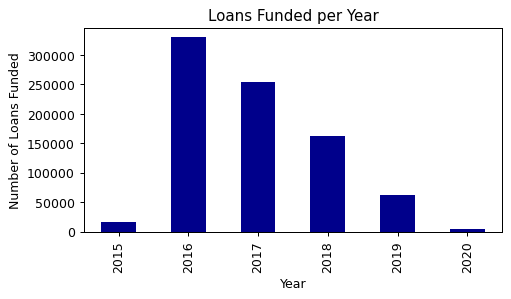

In [842]:
plt.figure(figsize=(6,3), dpi=90)
loans_df['issue_d'].dt.year.value_counts().sort_index().plot.bar(color='darkblue')
plt.xlabel('Year')
plt.ylabel('Number of Loans Funded')
plt.title('Loans Funded per Year')

In [3]:
# We'll form the test set from the most recent 10% of the loans.

loans_train = loans_df.loc[loans_df['issue_d'] <  loans_df['issue_d'].quantile(0.9)]
loans_test =  loans_df.loc[loans_df['issue_d'] >= loans_df['issue_d'].quantile(0.9)]

In [4]:
# What is the test size?
loans_test.shape[0] / loans_df.shape[0]

0.10408742778668219

In [5]:
loans_train.drop('issue_d', axis=1, inplace=True)
loans_test.drop('issue_d', axis=1, inplace=True)

y_train = loans_train['charged_off']
y_test = loans_test['charged_off']

X_train = loans_train.drop('charged_off', axis=1)
X_test = loans_test.drop('charged_off', axis=1)

/Users/gianluca/python_venv/lib/python3.7/site-packages/pandas/core/frame.py:3994: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [6]:
print("X_train.shape: ", X_train.shape)
print("X_test.shape:  ", X_test.shape)
print("y_train.shape: ", y_train.shape)
print("y_test.shape:  ", y_test.shape)

X_train.shape:  (741752, 180)
X_test.shape:   (86177, 180)
y_train.shape:  (741752,)
y_test.shape:   (86177,)


In [7]:
y_train.value_counts()

0    587588
1    154164
Name: charged_off, dtype: int64

In [8]:
y_test.value_counts()

0    71710
1    14467
Name: charged_off, dtype: int64

## 3. Model training - with class imbalance

### 3.1 Neural Network

In [11]:
# Neural network

scaler = MinMaxScaler()

# fit and transfrom
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# everything has been scaled between 1 and 0
print('Max: ',X_train.max())
print('Min: ', X_train.min())

Max:  1.0000000000000004
Min:  0.0


In [12]:
model = Sequential()

# input layer
model.add(Dense(X_train.shape[1],activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(39,activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(19,activation='relu'))
model.add(Dropout(0.2))

# output layer
model.add(Dense(1, activation='sigmoid'))

# compile model
model.compile(optimizer="adam", loss='binary_crossentropy')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [13]:
# Early Stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [14]:
model.fit(x=X_train, 
          y=y_train.values, 
          epochs=400,
          verbose = 2,
          batch_size=256,
          validation_data=(X_test, y_test.values),
          callbacks=[early_stop])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 741752 samples, validate on 86177 samples
Epoch 1/400
741752/741752 - 9s - loss: 0.0566 - val_loss: 0.0058
Epoch 2/400
741752/741752 - 8s - loss: 0.0190 - val_loss: 0.0044
Epoch 3/400
741752/741752 - 9s - loss: 0.0149 - val_loss: 0.0037
Epoch 4/400
741752/741752 - 10s - loss: 0.0131 - val_loss: 0.0037
Epoch 5/400
741752/741752 - 9s - loss: 0.0119 - val_loss: 0.0036
Epoch 6/400
741752/741752 - 9s - loss: 0.0110 - val_loss: 0.0036
Epoch 7/400
741752/741752 - 8s - loss: 0.0106 - val_loss: 0.0040
Epoch 8/400
741752/741752 - 10s - loss: 0.0100 - val_loss: 0.0033
Epoch 9/400
741752/741752 - 11s - loss: 0.0098 - val_loss: 0.0031
Epoch 10/400
741752/741752 - 11s - loss: 0.0092 - val_loss: 0.0028
Epoch 11/400
741752/741752 - 11s - loss: 0.0089 - val_loss: 0.0030
Epoch 12/400
741752/741752 - 11s - loss: 0.0086 - val_loss: 0.0037
Epoch 13/400
741752/741752 - 10s - loss: 0.0083 - val_loss: 0.0034

In [15]:
losses = pd.DataFrame(model.history.history)

In [16]:
predictions_nn = model.predict_classes(X_test)

print('Classification Report:')
print(classification_report(y_test, predictions_nn))
print('\n')
print('Confusion Matrix:')
print(confusion_matrix(y_test, predictions_nn))

cm_nn = confusion_matrix(y_test, predictions_nn)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71710
           1       1.00      1.00      1.00     14467

    accuracy                           1.00     86177
   macro avg       1.00      1.00      1.00     86177
weighted avg       1.00      1.00      1.00     86177



Confusion Matrix:
[[71707     3]
 [   25 14442]]


### 3.2 Random Forest

In [855]:
pipeline_rfc = Pipeline([
    ('imputer', SimpleImputer(copy=False)),
    ('model', RandomForestClassifier(n_jobs=-1, random_state=1))
])

In [856]:
param_grid_rfc = {
    'model__n_estimators': [50] # The number of randomized trees to build
}

In [857]:
grid_rfc = GridSearchCV(estimator=pipeline_rfc, param_grid=param_grid_rfc, scoring='roc_auc', n_jobs=1, pre_dispatch=1, cv=5, verbose=1, return_train_score=False)

In [858]:
grid_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer(copy=False)),
                                       ('model',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=1))]),
             n_jobs=1, param_grid={'model__n_estimators': [50]}, pre_dispatch=1,
             scoring='roc_auc', verbose=1)

In [18]:
grid_rfc.best_score_

0.9994086968039779

In [19]:
predictions_rfc = grid_rfc.predict(X_test)

print('Classification Report:')
print(classification_report(y_test, predictions_rfc))
print('\n')
print('Confusion Matrix:')
print(confusion_matrix(y_test, predictions_rfc))

cm_rfc = confusion_matrix(y_test, predictions_rfc)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71710
           1       1.00      1.00      1.00     14467

    accuracy                           1.00     86177
   macro avg       1.00      1.00      1.00     86177
weighted avg       1.00      1.00      1.00     86177



Confusion Matrix:
[[71710     0]
 [   59 14408]]


### 3.3 Logistic regressor

In [861]:
# Logistic regressor

pipeline_logreg = Pipeline([
    ('imputer', SimpleImputer(copy=False)), # Mean imputation by default
    ('scaler', StandardScaler(copy=False)),
    ('model', LogisticRegression(max_iter=1000, tol=1e-3, random_state=1, warm_start=True))
])

In [862]:
param_grid_logreg = {
    'model__C': [10**-5, 10**-2, 10**1]
}


In [863]:
grid_logreg = GridSearchCV(estimator=pipeline_logreg, param_grid=param_grid_logreg, scoring='roc_auc', n_jobs=1, pre_dispatch=1, cv=5, verbose=1, return_train_score=False)

In [864]:
grid_logreg.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer(copy=False)),
                                       ('scaler', StandardScaler(copy=False)),
                                       ('model',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=1,
                                                           tol=0.001,
                                                           warm_start=True))]),
             n_jobs=1, param_grid={'model__C': [1e-05, 0.01, 10]},
             pre_dispatch=1, scoring='roc_auc', verbose=1)

In [21]:
grid_logreg.best_score_

0.9997764408585109

In [22]:
grid_logreg.best_params_

{'model__C': 10}

In [23]:
predictions_logreg = grid_logreg.predict(X_test)

print('Classification Report:')
print(classification_report(y_test, predictions_logreg))
print('\n')
print('Confusion Matrix:')
print(confusion_matrix(y_test, predictions_logreg))

cm_logreg = confusion_matrix(y_test, predictions_logreg)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71710
           1       1.00      1.00      1.00     14467

    accuracy                           1.00     86177
   macro avg       1.00      1.00      1.00     86177
weighted avg       1.00      1.00      1.00     86177



Confusion Matrix:
[[71709     1]
 [   18 14449]]


### 3.4 Model comparison

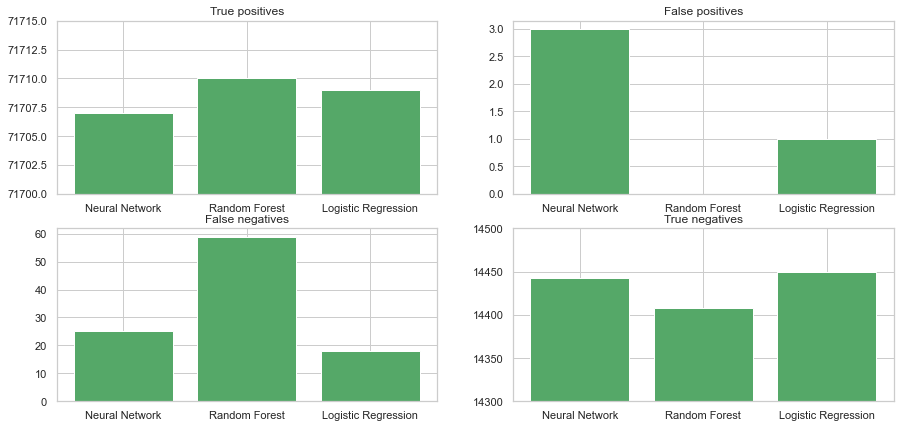

In [43]:
fig = plt.figure(figsize=(15,7))

cm_combined = np.vstack((cm_nn.ravel(), cm_rfc.ravel(), cm_logreg.ravel()))

plt.subplot(221)

plt.title("True positives")
plt.bar(np.arange(0,3), cm_combined[:,0])
plt.bar(np.arange(0,3), cm_combined[:,0])
plt.bar(np.arange(0,3), cm_combined[:,0])

plt.xticks(np.arange(0,3), ['Neural Network', 'Random Forest', 'Logistic Regression'])

plt.ylim([71700, 71715])

plt.subplot(222)

plt.title("False positives")

plt.bar(np.arange(0,3), cm_combined[:,1])
plt.bar(np.arange(0,3), cm_combined[:,1])
plt.bar(np.arange(0,3), cm_combined[:,1])

plt.xticks(np.arange(0,3), ['Neural Network', 'Random Forest', 'Logistic Regression'])

plt.subplot(223)

plt.title("False negatives")

plt.bar(np.arange(0,3), cm_combined[:,2])
plt.bar(np.arange(0,3), cm_combined[:,2])
plt.bar(np.arange(0,3), cm_combined[:,2])

plt.xticks(np.arange(0,3), ['Neural Network', 'Random Forest', 'Logistic Regression'])

plt.subplot(224)

plt.title("True negatives")

plt.bar(np.arange(0,3), cm_combined[:,3])
plt.bar(np.arange(0,3), cm_combined[:,3])
plt.bar(np.arange(0,3), cm_combined[:,3])

plt.xticks(np.arange(0,3), ['Neural Network', 'Random Forest', 'Logistic Regression'])

plt.ylim([14300, 14500])

plt.show()

## 4 Model training - without class imbalance

In [47]:
## Oversample the minority class in X train only

count_class_0, count_class_1 = loans_train.charged_off.value_counts()

X_train_class_0 = loans_train[loans_train['charged_off'] == 0]
X_train_class_1 = loans_train[loans_train['charged_off'] == 1]

In [48]:
X_train_class_0.shape

(587588, 181)

In [49]:
X_train_class_1.shape

(154164, 181)

In [53]:
X_train_class_1_over = X_train_class_1.sample(count_class_0, replace=True)
X_train_over = pd.concat([X_train_class_0, X_train_class_1_over], axis=0)

print('Random over-sampling:')
print(X_train_over.charged_off.value_counts())

Random over-sampling:
1    587588
0    587588
Name: charged_off, dtype: int64


In [54]:
y_train = X_train_over['charged_off']
y_test = loans_test['charged_off']

X_train = X_train_over.drop('charged_off', axis=1)
X_test = loans_test.drop('charged_off', axis=1)

In [55]:
print("X_train.shape: ", X_train.shape)
print("X_test.shape:  ", X_test.shape)
print("y_train.shape: ", y_train.shape)
print("y_test.shape:  ", y_test.shape)

X_train.shape:  (1175176, 180)
X_test.shape:   (86177, 180)
y_train.shape:  (1175176,)
y_test.shape:   (86177,)


### 4.1 Neural Network

In [56]:
# Neural network

scaler = MinMaxScaler()

# fit and transfrom
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# everything has been scaled between 1 and 0
print('Max: ',X_train.max())
print('Min: ', X_train.min())

Max:  1.0000000000000004
Min:  0.0


In [57]:
model = Sequential()

# input layer
model.add(Dense(X_train.shape[1],activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(39,activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(19,activation='relu'))
model.add(Dropout(0.2))

# output layer
model.add(Dense(1, activation='sigmoid'))

# compile model
model.compile(optimizer="adam", loss='binary_crossentropy')

In [58]:
# Early Stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [59]:
model.fit(x=X_train, 
          y=y_train.values, 
          epochs=400,
          verbose = 2,
          batch_size=256,
          validation_data=(X_test, y_test.values),
          callbacks=[early_stop])

Train on 1175176 samples, validate on 86177 samples
Epoch 1/400
1175176/1175176 - 19s - loss: 0.0500 - val_loss: 0.0099
Epoch 2/400
1175176/1175176 - 18s - loss: 0.0203 - val_loss: 0.0037
Epoch 3/400
1175176/1175176 - 17s - loss: 0.0161 - val_loss: 0.0038
Epoch 4/400
1175176/1175176 - 19s - loss: 0.0136 - val_loss: 0.0036
Epoch 5/400
1175176/1175176 - 19s - loss: 0.0126 - val_loss: 0.0035
Epoch 6/400
1175176/1175176 - 19s - loss: 0.0113 - val_loss: 0.0036
Epoch 7/400
1175176/1175176 - 20s - loss: 0.0106 - val_loss: 0.0030
Epoch 8/400
1175176/1175176 - 19s - loss: 0.0100 - val_loss: 0.0029
Epoch 9/400
1175176/1175176 - 18s - loss: 0.0092 - val_loss: 0.0030
Epoch 10/400
1175176/1175176 - 20s - loss: 0.0087 - val_loss: 0.0038
Epoch 11/400
1175176/1175176 - 19s - loss: 0.0082 - val_loss: 0.0032
Epoch 12/400
1175176/1175176 - 20s - loss: 0.0077 - val_loss: 0.0036
Epoch 13/400
1175176/1175176 - 19s - loss: 0.0072 - val_loss: 0.0036
Epoch 14/400
1175176/1175176 - 19s - loss: 0.0069 - val_loss

In [60]:
losses = pd.DataFrame(model.history.history)

In [61]:
predictions_nn_over = model.predict_classes(X_test)

print('Classification Report:')
print(classification_report(y_test, predictions_nn_over))
print('\n')
print('Confusion Matrix:')
print(confusion_matrix(y_test, predictions_nn_over))

cm_nn_over = confusion_matrix(y_test, predictions_nn_over)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71710
           1       1.00      1.00      1.00     14467

    accuracy                           1.00     86177
   macro avg       1.00      1.00      1.00     86177
weighted avg       1.00      1.00      1.00     86177



Confusion Matrix:
[[71705     5]
 [   25 14442]]


### 4.2 Random Forest

In [63]:
pipeline_rfc = Pipeline([
    ('imputer', SimpleImputer(copy=False)),
    ('model', RandomForestClassifier(n_jobs=-1, random_state=1))
])

In [64]:
param_grid_rfc = {
    'model__n_estimators': [50] # The number of randomized trees to build
}

In [65]:
grid_rfc = GridSearchCV(estimator=pipeline_rfc, param_grid=param_grid_rfc, scoring='roc_auc', n_jobs=1, pre_dispatch=1, cv=5, verbose=1, return_train_score=False)

In [66]:
grid_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer(copy=False)),
                                       ('model',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=1))]),
             n_jobs=1, param_grid={'model__n_estimators': [50]}, pre_dispatch=1,
             scoring='roc_auc', verbose=1)

In [67]:
grid_rfc.best_score_

0.9999684299163063

In [68]:
predictions_rfc_over = grid_rfc.predict(X_test)

print('Classification Report:')
print(classification_report(y_test, predictions_rfc_over))
print('\n')
print('Confusion Matrix:')
print(confusion_matrix(y_test, predictions_rfc_over))

cm_rfc_over = confusion_matrix(y_test, predictions_rfc_over)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71710
           1       1.00      1.00      1.00     14467

    accuracy                           1.00     86177
   macro avg       1.00      1.00      1.00     86177
weighted avg       1.00      1.00      1.00     86177



Confusion Matrix:
[[71709     1]
 [   68 14399]]


### 4.3 Logistic regressor

In [72]:
# Logistic regressor

pipeline_logreg = Pipeline([
    ('imputer', SimpleImputer(copy=False)), # Mean imputation by default
    ('scaler', StandardScaler(copy=False)),
    ('model', LogisticRegression(max_iter=1000, tol=1e-3, random_state=1, warm_start=True))
])

In [73]:
param_grid_logreg = {
    'model__C': [10**-5, 10**-2, 10**1]
}

In [74]:
grid_logreg = GridSearchCV(estimator=pipeline_logreg, param_grid=param_grid_logreg, scoring='roc_auc', n_jobs=1, pre_dispatch=1, cv=5, verbose=1, return_train_score=False)

In [75]:
grid_logreg.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer(copy=False)),
                                       ('scaler', StandardScaler(copy=False)),
                                       ('model',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=1,
                                                           tol=0.001,
                                                           warm_start=True))]),
             n_jobs=1, param_grid={'model__C': [1e-05, 0.01, 10]},
             pre_dispatch=1, scoring='roc_auc', verbose=1)

In [76]:
grid_logreg.best_score_

0.99985133607692

In [77]:
grid_logreg.best_params_

{'model__C': 10}

In [78]:
predictions_logreg_over = grid_logreg.predict(X_test)

print('Classification Report:')
print(classification_report(y_test, predictions_logreg_over))
print('\n')
print('Confusion Matrix:')
print(confusion_matrix(y_test, predictions_logreg_over))

cm_logreg_over = confusion_matrix(y_test, predictions_logreg_over)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71710
           1       1.00      1.00      1.00     14467

    accuracy                           1.00     86177
   macro avg       1.00      1.00      1.00     86177
weighted avg       1.00      1.00      1.00     86177



Confusion Matrix:
[[71709     1]
 [   11 14456]]


### 4.4 Model comparison

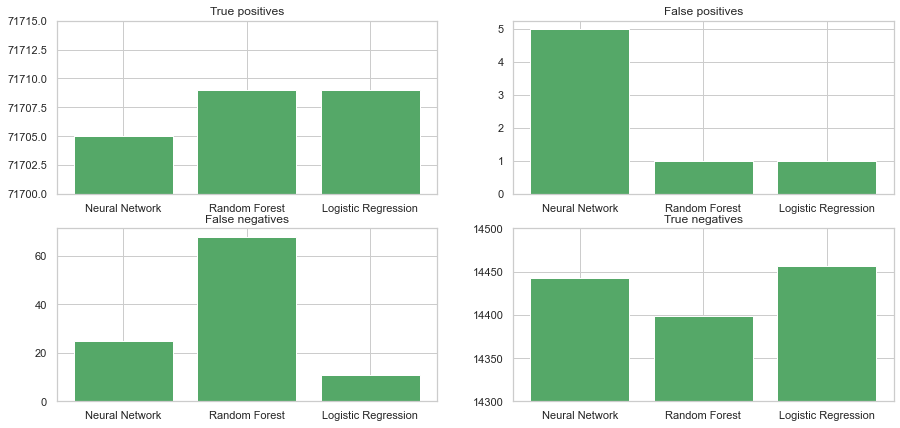

In [79]:
fig = plt.figure(figsize=(15,7))

cm_combined_over = np.vstack((cm_nn_over.ravel(), cm_rfc_over.ravel(), cm_logreg_over.ravel()))

plt.subplot(221)

plt.title("True positives")
plt.bar(np.arange(0,3), cm_combined_over[:,0])
plt.bar(np.arange(0,3), cm_combined_over[:,0])
plt.bar(np.arange(0,3), cm_combined_over[:,0])

plt.xticks(np.arange(0,3), ['Neural Network', 'Random Forest', 'Logistic Regression'])

plt.ylim([71700, 71715])

plt.subplot(222)

plt.title("False positives")

plt.bar(np.arange(0,3), cm_combined_over[:,1])
plt.bar(np.arange(0,3), cm_combined_over[:,1])
plt.bar(np.arange(0,3), cm_combined_over[:,1])

plt.xticks(np.arange(0,3), ['Neural Network', 'Random Forest', 'Logistic Regression'])

plt.subplot(223)

plt.title("False negatives")

plt.bar(np.arange(0,3), cm_combined_over[:,2])
plt.bar(np.arange(0,3), cm_combined_over[:,2])
plt.bar(np.arange(0,3), cm_combined_over[:,2])

plt.xticks(np.arange(0,3), ['Neural Network', 'Random Forest', 'Logistic Regression'])

plt.subplot(224)

plt.title("True negatives")

plt.bar(np.arange(0,3), cm_combined_over[:,3])
plt.bar(np.arange(0,3), cm_combined_over[:,3])
plt.bar(np.arange(0,3), cm_combined_over[:,3])

plt.xticks(np.arange(0,3), ['Neural Network', 'Random Forest', 'Logistic Regression'])

plt.ylim([14300, 14500])

plt.show()